# <span style="color:green">Algoritmi Genetici per Serie Finanziarie</span>

- Compattamento Codice.
- Aggiunta funzione "load_data_intraday".
- Aggiunta funzione "create_rules".
- Aggiunta INSTABILITY_FACTOR nella funzione "all_gains".
- Aggiunta INSTRUMENT nella funzione "operation_gain".
- Aggiunta Fitness Functions alternative e composte.

In [1]:
!python --version

Python 3.8.12


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numba

In [3]:
%run ./engine_gandalf_wintermute.py
%run ./functions_gandalf_wintermute.py

5.3.1


### <span style="color:red">Aggiungiamo una funzione per il caricamento della serie finanziaria intraday:</span>

In [4]:
def load_data_daily(filename):
    """
    Funzione per il caricamento di uno storico daily
    Fonte dati: Tradestation .txt
    """
    
    import datetime
    start = datetime.datetime.now()
    
    data = pd.read_csv(filename, parse_dates = ["Date","Time"])
    data.columns = ["date","time","open","high","low","close","volume","oi"]
    data.set_index("date", inplace = True)
    data.drop(["time","oi"], axis=1, inplace=True)
    data["dayofweek"] = data.index.dayofweek
    data["day"] = data.index.day
    data["month"] = data.index.month
    data["year"] = data.index.year
    data["dayofyear"] = data.index.dayofyear
    data["quarter"] = data.index.quarter
    
    end = datetime.datetime.now()
    print("loaded", len(data), "records in", end - start)
    
    return data


def load_data_intraday(filename):
    """
    Funzione per il parsing di una serie intraday 
    con estensione txt esportata da Tradestation
    """
    
    import datetime
    start = datetime.datetime.now()

    data = pd.read_csv(filename, 
                       usecols = ['Date','Time','Open','High','Low','Close','Up','Down'], 
                       parse_dates = [['Date', 'Time']])
    data.columns = ["date_time","open","high","low","close","up","down"]
    data.set_index('date_time', inplace = True)
    data['volume'] = data['up'] + data['down']
    data.drop(['up','down'], axis = 1,inplace = True)
    data["dayofweek"] = data.index.dayofweek
    data["day"] = data.index.day
    data["month"] = data.index.month
    data["year"] = data.index.year
    data["dayofyear"] = data.index.dayofyear
    data["quarter"] = data.index.quarter
    data["hour"] = data.index.hour
    data["minute"] = data.index.minute
    
    #data["daily_open"] = daily_open(data,0)
    #data["daily_open1"] = daily_open(data,1)
    #data["daily_high1"] = daily_high(data,1)
    #data["daily_low1"] = daily_low(data,1)
    #data["daily_close1"] = daily_close(data,1)
    
    end = datetime.datetime.now()
    print("loaded", len(data), "records in", end - start)
    
    return data.dropna()
   

FILENAME = "data/@GC_60min_Exchange.txt"

%time dataset = load_data_intraday(FILENAME)
dataset.head()

loaded 92284 records in 0:00:08.024763
Wall time: 8.04 s


,open,high,low,close,volume,dayofweek,day,month,year,dayofyear,quarter,hour,minute
date_time,,,,,,,,,,,,,
2007-01-01 19:00:00,977.2,978.3,976.5,977.2,1022,0,1,1,2007,1,1,19,0
2007-01-01 20:00:00,976.9,977.7,976.5,977.1,294,0,1,1,2007,1,1,20,0
2007-01-01 21:00:00,977.4,977.8,977.0,977.4,358,0,1,1,2007,1,1,21,0
2007-01-01 22:00:00,977.6,977.9,977.3,977.8,326,0,1,1,2007,1,1,22,0
2007-01-01 23:00:00,977.8,977.9,977.4,977.8,178,0,1,1,2007,1,1,23,0


"""
aggiunta di campi al DataFrame di base
per popolare la Genetic Pool desiderata
"""

dataset["avg5"] = dataset.close.rolling(5).mean()
dataset["avg10"] = dataset.close.rolling(10).mean()
dataset["avg20"] = dataset.close.rolling(20).mean()
dataset["avg50"] = dataset.close.rolling(50).mean()
dataset["avg100"] = dataset.close.rolling(100).mean()
dataset["avg200"] = dataset.close.rolling(200).mean()

dataset["min5"] = dataset.low.rolling(5).min()
dataset["min10"] = dataset.low.rolling(10).min()
dataset["min20"] = dataset.low.rolling(20).min()
dataset["min50"] = dataset.low.rolling(50).min()
dataset["min100"] = dataset.low.rolling(100).min()
dataset["min200"] = dataset.low.rolling(200).min()

dataset["max5"] = dataset.high.rolling(5).max()
dataset["max10"] = dataset.high.rolling(10).max()
dataset["max20"] = dataset.high.rolling(20).max()
dataset["max50"] = dataset.high.rolling(50).max()
dataset["max100"] = dataset.high.rolling(100).max()
dataset["max200"] = dataset.high.rolling(200).max()

dataset.dropna(inplace = True)

dataset.head()

In [5]:
log_price=["OpenToLowLog",
"OpenToAvgPriceLog",
"OpenToMedPriceLog",
"OpenToOpenLog",
"OpenToMedBodyPriceLog",
"CloseToMedPriceLog",
"CloseToCloseLog",
"CloseToLowLog",
"CloseToAvgPriceLog",
"CloseToMedBodyPriceLog",
"HighToCloseLog",
"HighToOpenLog",
"HighToMedBodyPriceLog",
"HighToMedPriceLog",
"HighToAvgPriceLog",
"HighToHighLog",
"LowToLowLog",
"AvgPriceToMedPriceLog",
"AvgPriceToLowLog",
"AvgPriceToAvgPriceLog",
"AvgPriceToMedBodyPriceLog",
"MedPriceToLowLog",
"MedBodyPriceToLowLog",
"MedPriceToMedBodyPriceLog",
"MedPriceToMedPriceLog",
"MedBodyPriceToMedBodyPriceLog",
"RangeLog",
"BodyLog",
"BodyToRangeLog"]

for e in log_price:
    dataset[e]=eval(e+"(dataset)")

In [6]:
dataset.dropna(inplace = True)

dataset.head()

,open,high,low,close,volume,dayofweek,day,month,year,dayofyear,...,AvgPriceToAvgPriceLog,AvgPriceToMedBodyPriceLog,MedPriceToLowLog,MedBodyPriceToLowLog,MedPriceToMedBodyPriceLog,MedPriceToMedPriceLog,MedBodyPriceToMedBodyPriceLog,RangeLog,BodyLog,BodyToRangeLog
date_time,,,,,,,,,,,,,,,,,,,,,
2007-01-01 20:00:00,976.9,977.7,976.5,977.1,294,0,1,1,2007,1,...,-0.000256,0.000051,0.000614,0.000512,0.000102,-0.000307,-0.000205,0.001228,0.000205,-1.791759
2007-01-01 21:00:00,977.4,977.8,977.0,977.4,358,0,1,1,2007,1,...,0.000358,0.000000,0.000409,0.000409,0.000000,0.000307,0.000409,0.000818,0.000000,-inf
2007-01-01 22:00:00,977.6,977.9,977.3,977.8,326,0,1,1,2007,1,...,0.000256,-0.000051,0.000307,0.000409,-0.000102,0.000205,0.000307,0.000614,0.000205,-1.098612
2007-01-01 23:00:00,977.8,977.9,977.4,977.8,178,0,1,1,2007,1,...,0.000077,-0.000077,0.000256,0.000409,-0.000153,0.000051,0.000102,0.000511,0.000000,-inf
2007-01-02 00:00:00,977.8,978.2,977.8,977.8,262,1,2,1,2007,2,...,0.000179,0.000102,0.000205,0.000000,0.000205,0.000358,0.000000,0.000409,0.000000,-inf


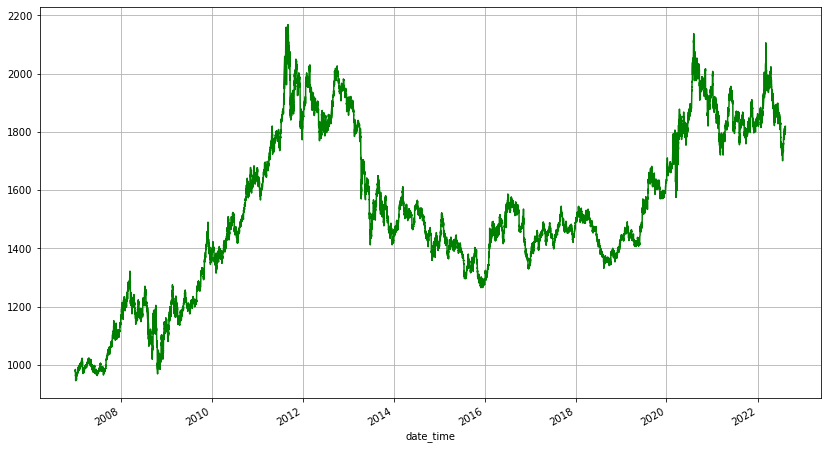

In [7]:
dataset.close.plot(figsize = (14, 8), grid = True, color = "green");

### Generazione regole e formule corrispondenti

### <span style="color:red">Aggiungiamo la funzione "create_rules":</span>

In [8]:
def generate_rule(dataset, element1, offset1, element2, offset2):
    """
    Funzione che genera una regola (colonna del Pandas DataFrame) 
    del tipo element1(offset) > element2(offset)
    """
    return dataset[element1].shift(offset1) > dataset[element2].shift(offset2)


def generate_rule_formula(element1, offset1, element2, offset2):
    """
    Funzione che genera la formula associata "element1(offset) > element2(offset)"
    """
    return element1 + "(" + str(offset1) + ") > " + element2 + "(" + str(offset2) + ")"


def create_rules(dataset):
    """
    Funzione che genera la matrice delle regole booleane
    e tutte le formule associate "element1(offset) > element2(offset)"
    """
    
    rules = pd.DataFrame()
    rule_formulas = []
    i = 0
    for element1 in GENETIC_POOL:
        for offset1 in range(0, MAX_OFFSET + 1):
            for element2 in GENETIC_POOL:
                for offset2 in range(0, MAX_OFFSET + 1):
                    if (element1 != element2) | (offset1 != offset2):
                        rule = generate_rule(dataset, element1, offset1, element2, offset2)
                        if not (np.all(rule == 0) | np.all(rule == 1)):
                            rules[i] = rule
                            rule_formulas.append(generate_rule_formula(element1, offset1, element2, offset2))
                            i += 1
                        
    return rules, rule_formulas


GENETIC_POOL = log_price 
#["open", "high", "low", "close", 
#"avg5", "avg10", "avg20", "avg50", "avg100","avg200",
#"min5", "min10", "min20", "min50", "min100","min200",
#"max5", "max10", "max20", "max50", "max100","max200",]

MAX_OFFSET = 4

%time rules, rule_formulas = create_rules(dataset)

Wall time: 58.5 s


In [9]:
print("Numero regole generate:",len(rules.columns))

Numero regole generate: 19765


In [10]:
rules.head()

,0,1,2,3,4,5,6,7,8,9,...,19755,19756,19757,19758,19759,19760,19761,19762,19763,19764
date_time,,,,,,,,,,,,,,,,,,,,,
2007-01-01 20:00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2007-01-01 21:00:00,False,False,False,False,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2007-01-01 22:00:00,False,False,False,False,True,True,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
2007-01-01 23:00:00,True,False,False,False,True,True,True,False,True,True,...,False,False,False,False,False,False,False,False,False,False
2007-01-02 00:00:00,False,False,False,False,False,True,False,True,False,False,...,False,False,False,False,False,False,True,True,False,True


### Lista Funzioni

### <span style="color:red">Aggiungiamo il campo INSTRUMENT nella funzione "operation_gain", per discriminare gli strumenti:</span>

In [212]:
@numba.jit(nopython = True) # ACCELERAZIONE NUMBA: invochiamo Numba per eseguire il metodo operation_gain()
def operation_gain(setup_idx,direction): # ACCELARAZIONE NUMPY: passiamo l'indice e non il tempo
    """
    Funzione che calcola il guadagno di una singola operazione ad un certo indice
    """
    # entra il giorno successivo a un setup ed esce TIME_EXIT giorno dopo l'ingresso
    enter_idx = setup_idx + 1
    exit_idx = enter_idx + TIME_EXIT
    if (enter_idx < 1) |\
       (exit_idx > len(close_array) - 1): # ACCELARAZIONE NUMPY: usiamo l'array al posto del dataframe per la max lunghezza
        return 0

    # cerca i livello di setup, ingresso e uscita
    setup_level = close_array[setup_idx] # ACCELARAZIONE NUMPY: uso l'array al posto del dataframe
    enter_level = open_array[enter_idx] # ACCELARAZIONE NUMPY: uso l'array al posto del dataframe
    exit_level = open_array[exit_idx]   # ACCELARAZIONE NUMPY: uso l'array al posto del dataframe
    
    # calcola il numero di contrattioperation_gain
    if INSTRUMENT == 1:
        contracts = np.floor(CAPITAL / setup_level)
    if INSTRUMENT == 2:
        contracts = CAPITAL * BIGPOINTVALUE
    if INSTRUMENT == 3:
        contracts = CAPITAL / setup_level

    # calcola il guadagno, invertendo il segno se è un'operazione short
    #print(setup_idx, enter_level, exit_level)
    gain = contracts * (exit_level - enter_level)
    if direction == "short":
        gain = -gain
        
    return gain

### <span style="color:red">Aggiungiamo il campo INSTABILITY_FACTOR nella funzione "all_gains", per rendere probabilistica la possibilità di compiere un trade generato da una determinata regola:</span>

In [11]:
def all_gains(dna):
    """
    Funzione che calcola la lista di tutti i guadagni di un dato DNA
    """
    gains = []
    
    # trova i tempi di setup
    ss = setups(numba.typed.List(dna)) # ACCELERAZIONE NUMBA: debbiamo passare una lista compatibile con Numba
    ss_idxs = np.where(ss == True)[0]

    # per ogni tempo di setup calcola il profitto e lo aggiunge alla lista
    for idx in ss_idxs:
        time = times_array[idx]
        gain = operation_gain(idx,DIRECTION)
        if (np.random.random() < (1 - INSTABILITY_FACTOR)):
            gains.append((time, gain))
    return gains

In [12]:
def rnd_gene():
    """
    Funzione che attiva un gene casuale
    cioè un indice di colonna nella tabella rules.
    """
    return np.random.randint(0, len(rules.columns) - 1)


def rnd_dna():
    """
    Funzione che genera un dna casuale (a singolo cromosoma, solo regole in "and" logico).
    """
    dna = []
    for i in range(0, DNA_SIZE):
        dna.append(rnd_gene())
    return dna


def first_generation():
    """
    Funzione che genera un dataframe con la popolazione iniziale casuale. 
    Ogni riga corrisponde a un DNA cioè ad un investitore artificiale.
    """
    population = pd.DataFrame(index = range(POPULATION_SIZE), columns = range(DNA_SIZE))
    for i in range(0, POPULATION_SIZE):
        population.iloc[i] = rnd_dna()
    return population


def dna_formula(dna):
    """
    Funzione che calcola la formula di un DNA (a singolo cromosoma).
    """
    formula = ""
    for gene in dna:
        if len(formula) != 0:
            formula += " and "
        formula += rule_formulas[gene]
    return formula


@numba.jit(nopython = True) # ACCELARAZIONE NUMBA: aggiungo un'annotazione per compilare il metodo setups() con Numba
def setups(dna):
    """
    Funzione che calcola i setups di un dna (ad unico cromosoma) su tutte le regole
    Versione che sostituisce la precedente funzione in Pandas
    """
    setups = None
    for gene in dna:
        if setups is None:
            setups = rules_array[gene] # ACCELARAZIONE NUMPY: usiamo l'array al posto del dataframe
        else:
            setups = setups & rules_array[gene] # ACCELARAZIONE NUMPY: usiamo l'array al posto del dataframe
    return setups


def plot_equity(dna):
    """
    Funzione che grafichi l'equity line risultatnte 
    dato un DNA.
    """
    gains = all_gains(dna)
    times, gains = zip(*gains)
    profits = np.array(gains).cumsum()
    equity = pd.Series(profits, times)
    equity.plot(figsize=(14, 8), grid = True)

    
def sort_population(population):
    """
    Funzione per operare un ordinamento della popolazione
    rispetto alla fitness function
    """
    scores = population.apply(lambda dna: fitness(dna), axis = 1)
    sorted_population = population.copy()
    sorted_population["Score"] = scores
    sorted_population.sort_values(by = ["Score"], ascending = [False], inplace = True)
    sorted_population.reset_index(drop = True, inplace = True)
    sorted_population.drop(sorted_population.columns[[-1,]], axis = 1, inplace = True)
    return sorted_population


def mutation(mut_prob,dna1):
    """
    Funzione che muta un DNA cambiando ogni gene con un gene casuale
    con probabilità MUTATION_PROB.
    """
    dna = []
    for i in range(DNA_SIZE):
        if np.random.random() < mut_prob:
            dna.append(rnd_gene())
        else:
            dna.append(dna1[i])
    return dna


def crossover(dna1, dna2):
    """
    Funzione che, presi due DNA, in modo randomico, 
    prende il gene di uno dei due genitori
    """
    dna = []
    for i in range(DNA_SIZE):
        if np.random.randint(2) == 0:
            dna.append(dna1[i])
        else:
            dna.append(dna2[i])
    return dna

### <span style="color:red">Aggiungiamo nuove Fitness Functions alternative (e combinazioni di esse):</span>

In [13]:
def profit(dna):
    """
    Fitness Function basata sul Profit totale.
    """
    gains = all_gains(dna)
       
    ops = len([gain for (time, gain) in gains])
    
    if ops >= MIN_OPERATIONS:
        return round(sum([gain for (time, gain) in gains]),2)
    else:
        return 0
    
    
def max_drawdown(dna):
    """
    Fitness Function basata sul Draw Down.
    """
    gains = all_gains(dna)
    ops = len([gain for (time, gain) in gains])
    eq = np.cumsum([i[1] for i in gains])

    eq_top_list = []
    eq_top = 0
    for el in eq:
        if el > eq_top:
            eq_top = el
        eq_top_list.append(eq_top)

    #print(len(eq),len(eq_top_list))
    
    dd = eq - eq_top_list
    
    if ops >= MIN_OPERATIONS and len(dd) != 0:
        return min(dd)
    else:
        return -np.inf
    
    
def avg_trade(dna):
    """
    Fitness Function basata sul AvgTrade.
    """
    gains = all_gains(dna)
    ops = len([gain for (time, gain) in gains])
    my_sum = sum([gain for (time, gain) in gains])
    
    if ops == 0 or ops < MIN_OPERATIONS:
        return 0
    else:
        return my_sum / ops
    
    
def gross_profit(dna):
    """
    Fitness Function basata sul Gross Profit.
    """
    gains = all_gains(dna)
    ops = len([gain for (time, gain) in gains])
    pos_sum = sum([gain for (time, gain) in gains if gain > 0])
    
    if ops < MIN_OPERATIONS:
        return 1
    else:
        return pos_sum
    

def profit_factor(dna):
    """
    Fitness Function basata sul Profit Factor.
    """
    gains = all_gains(dna)
    
    ops = len([gain for (time, gain) in gains])
    pos_sum = sum([gain for (time, gain) in gains if gain > 0])
    neg_sum = sum([gain for (time, gain) in gains if gain < 0])
    #print(pos_sum,neg_sum)
    
    if neg_sum == 0 or ops < MIN_OPERATIONS:
        return 0
    else:
        return round(abs(pos_sum / neg_sum),2)
    
    
def fitness(dna):
    """
    Funzione che associa la funzione di fitness
    su cui operare l'ordinamento al termine di ciascuna generazione
    """
    if FITNESS_FUNCTION == "Profit":
        return profit(dna)
    if FITNESS_FUNCTION == "AvgTrade":
        return avg_trade(dna)
    if FITNESS_FUNCTION == "ProfitFactor":
        return profit_factor(dna)
    if FITNESS_FUNCTION == "GrossProfit":
        return gross_profit(dna)
    if FITNESS_FUNCTION == "Profit/MaxDrawDown":
        return profit(dna) / -max_drawdown(dna)
    if FITNESS_FUNCTION == "AvgTrade/MaxDrawDown":
        return avg_trade(dna) / -max_drawdown(dna)

### Architettura Genetica:

In [14]:
def next_generation(population):
    """
    Funzione che riporta la generazione successiva
    """
    n = len(population.index)
    n_best = int(n * BEST_DNA_RATIO)
    n_cross = int(n * CROSS_DNA_RATIO)
    n_mutate = n - n_best - n_cross

    new_population = pd.DataFrame(index = range(POPULATION_SIZE), columns = range(DNA_SIZE))

    # copia i migliori DNA
    for i in range(n_best):
        new_population.iloc[i] = population.iloc[i]

    # aggiunge gli incroci
    for i in range(n_cross):
        dna1 = population.iloc[np.random.randint(n_best)]
        dna2 = population.iloc[np.random.randint(n_best)]
        dna = crossover(dna1, dna2)
        new_population.iloc[n_best + i] = dna

    # aggiunge le mutazioni
    for i in range(n_mutate):
        dna1 = population.iloc[np.random.randint(n_best)]
        dna = mutation(MUTATION_PROB, dna1)
        new_population.iloc[n_best + n_cross + i] = dna

    return new_population


def print_best(population, gen_num):
    """
    Funzione per la stampa delle performance del migliore investitore/DNA
    di una determinata generazione.
    """
    best_dna = population.iloc[0]    
    #tf = total_profit(best_dna)
    tf = fitness(best_dna)
    print("generation", gen_num, ":", round(tf, 2), " ", dna_formula(best_dna))


def evolution():
    """
    Funzione che definisce il ciclo principale dell'algoritmo genetico
    """
    best_dnas = []
    population = first_generation()
    population = sort_population(population)
    best_dnas.append(population.iloc[0].values)
    print_best(population, 0)
    
    # evolve for NUM_GENERATIONS generations
    for i in range(1, NUM_GENERATIONS):
        population = next_generation(population)
        population = sort_population(population)
        best_dnas.append(population.iloc[0].values)
        print_best(population, i)

    return best_dnas

In [15]:
from numba import jit
@jit(nopython=True)
def numba_engine(rule,TIME_EXIT,target_monetario,COSTS_FIXED):
    
    for el in range(len(rule)):
        if rule[el] == 1:
            rule[el+1:el+TIME_EXIT+1]=0
    d=rule*target_monetario
    d[d != 0 ]=d[d != 0 ]-(COSTS_FIXED*2)
    return d

def target(DIRECTION,TIME_EXIT,dataset):
    price=dataset.open.copy()
    t_m=[]
    t_m=price.shift(-TIME_EXIT)-price
    t_m=t_m.shift(-1)
    t_m=t_m.fillna(0)
    if DIRECTION == "long":
        t_m=np.array(t_m * BIGPOINTVALUE)
    else:
        t_m=t_m*(-1)
        t_m=np.array(t_m * BIGPOINTVALUE)
    return t_m

def all_gains(dna):
    
    rule = setups(numba.typed.List(dna))
    rule.setflags(write=1)
    gains = numba_engine(rule,TIME_EXIT,gains_array,COSTS_FIXED)
    gains = gains[:-5000]
    tmp_times_array = times_array[:-5000]
    ls=[]
    for e in range(len(gains)):
        if gains[e]!=0:
            ls.append([tmp_times_array[e],gains[e]])

    return ls

### Codice di Esecuzione

In [17]:
INSTRUMENT = 2  # 1: equity, 2: future, 3: crypto/forex
CAPITAL = 1  # money per trade (case INSTRUMENTS = 1,3) or number of contracts (case INSTRUMENTS = 2)
BIGPOINTVALUE = 100
COSTS_FIXED = 25

TIME_EXIT = 5
DIRECTION = "long"

POPULATION_SIZE = 100
NUM_GENERATIONS = 20

DNA_SIZE = 8
BEST_DNA_RATIO = 0.3
CROSS_DNA_RATIO = 0.3
MUTATION_PROB = 0.1

# Profit
# AvgTrade
# ProfitFactor
# GrossProfit
# Profit/MaxDrawDown
# AvgTrade/MaxDrawDown
FITNESS_FUNCTION = "AvgTrade"
MIN_OPERATIONS = 500

INSTABILITY_FACTOR = 0.3

np.random.seed(None)

population = first_generation()

# Conversioni per Numba
rules_array = rules.values.T
open_array = dataset.open.values
close_array = dataset.close.values
times_array = dataset.index.values
gains_array = target(DIRECTION,TIME_EXIT,dataset) 

%time best_dnas = evolution()

generation 0 : 11.75   MedPriceToMedPriceLog(4) > HighToMedPriceLog(2) and LowToLowLog(3) > OpenToMedBodyPriceLog(4) and AvgPriceToLowLog(0) > HighToMedPriceLog(3) and CloseToLowLog(1) > AvgPriceToMedPriceLog(4) and RangeLog(1) > RangeLog(2) and MedBodyPriceToMedBodyPriceLog(1) > CloseToMedPriceLog(0) and RangeLog(2) > MedPriceToMedPriceLog(4) and CloseToCloseLog(2) > CloseToMedPriceLog(3)
generation 1 : 11.75   MedPriceToMedPriceLog(4) > HighToMedPriceLog(2) and LowToLowLog(3) > OpenToMedBodyPriceLog(4) and AvgPriceToLowLog(0) > HighToMedPriceLog(3) and CloseToLowLog(1) > AvgPriceToMedPriceLog(4) and RangeLog(1) > RangeLog(2) and MedBodyPriceToMedBodyPriceLog(1) > CloseToMedPriceLog(0) and RangeLog(2) > MedPriceToMedPriceLog(4) and CloseToCloseLog(2) > CloseToMedPriceLog(3)
generation 2 : 19.31   HighToHighLog(4) > OpenToLowLog(2) and CloseToLowLog(4) > OpenToMedPriceLog(3) and HighToAvgPriceLog(2) > HighToCloseLog(0) and OpenToOpenLog(2) > AvgPriceToMedBodyPriceLog(4) and CloseToMedB

In [18]:
# stampa dei primi 10 DNA (i migliori delle prime 10 generazioni)
best_dnas

[array([17178, 11370, 12386, 4807, 18236, 17424, 18373, 4178], dtype=object),
 array([17178, 11370, 12386, 4807, 18236, 17424, 18373, 4178], dtype=object),
 array([10772, 5161, 9815, 2449, 6312, 18144, 17844, 19004], dtype=object),
 array([19015, 19007, 5864, 11077, 4618, 18144, 9361, 15906], dtype=object),
 array([19015, 19007, 5864, 11077, 4618, 18144, 9361, 15906], dtype=object),
 array([19015, 19007, 5864, 11077, 4618, 18144, 9361, 15906], dtype=object),
 array([19015, 19007, 5864, 11077, 4618, 18144, 9361, 15906], dtype=object),
 array([19015, 18199, 7857, 11077, 4618, 18144, 18373, 15906], dtype=object),
 array([19015, 12478, 18601, 11077, 4618, 18144, 9361, 15906], dtype=object),
 array([19015, 19007, 5864, 11077, 14808, 18144, 18373, 15906],
       dtype=object),
 array([19015, 12478, 8954, 11077, 4618, 18144, 9361, 15906], dtype=object),
 array([19015, 12478, 8954, 11077, 4618, 18144, 9361, 15906], dtype=object),
 array([19015, 12478, 8954, 11077, 4618, 18144, 9361, 15906], dt

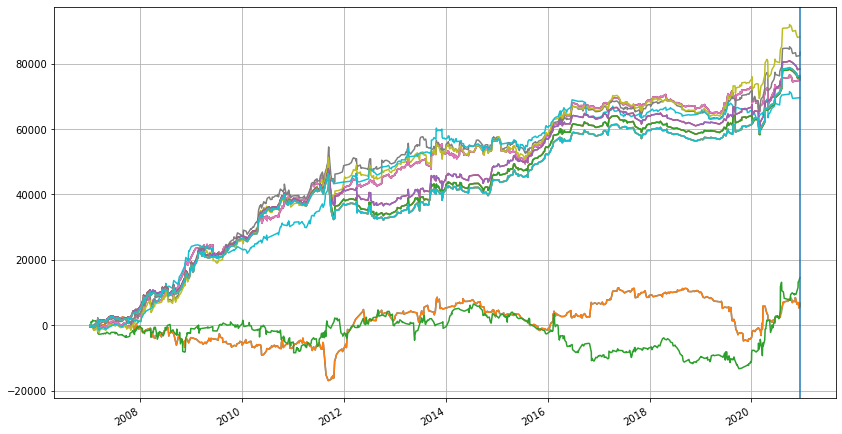

In [19]:
for el in best_dnas:
    plot_equity(el)
plt.axvline(x=dataset.iloc[:-5000].index[-1])

In [20]:
# stampa la fitness del miglior DNA dell'ultima generazione
last_dna = best_dnas[-1]
fitness(last_dna)

152.2554890219559

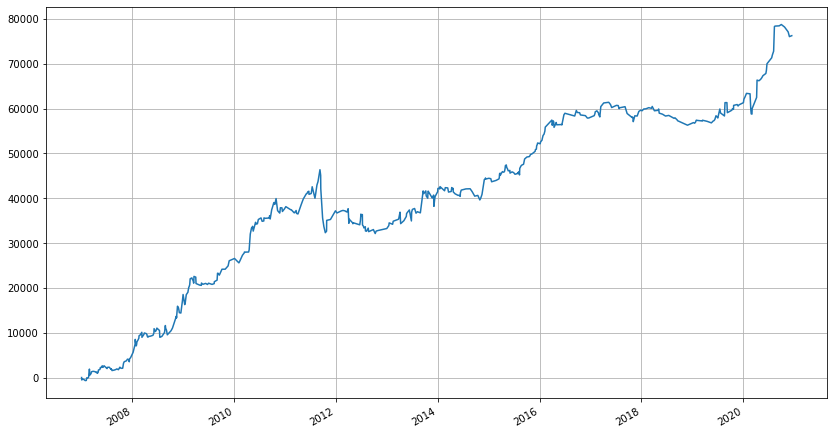

In [21]:
plot_equity(last_dna)
#plot_equity(best_dnas[0])

<AxesSubplot:>

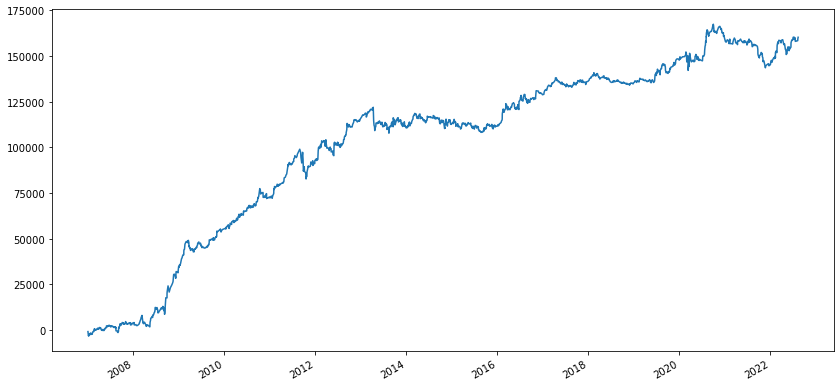

In [335]:
tradelist_l.operations.cumsum().plot(figsize=(14,7))

In [22]:
dataset["entry_rule"] = setups(numba.typed.List(last_dna))


Elaboration starting at: 2022-12-13 18:57:06.060419
Elaboration completed at: 2022-12-13 18:58:15.162962 in 0:01:09.102543

Consistency check: entries: 549 exits: 549

Last trade still open: we close it on last bar and we compute open position as closed position!

*****************************************************************************************
*** Performance Report - by Gandalf Project R&D - Version Wintermute - Copyright 2022 ***
*****************************************************************************************

CAGR:                     3.25 (capital = 100000)
Annual Return:            4.18 (capital = 100000)

Calmar Ratio:             1.88 (yearly)
Sharpe Ratio:             0.65 (initial capital = 100000, risk free rate = 0.0)
Sortino Ratio:            0.68 (initial capital = 100000, risk free rate = 0.0)
Omega Ratio:              1.07 (threshold = 100)
Kestner Ratio:            0.25

Operations:               549

Profit:                   66910.0
Average Trade:  

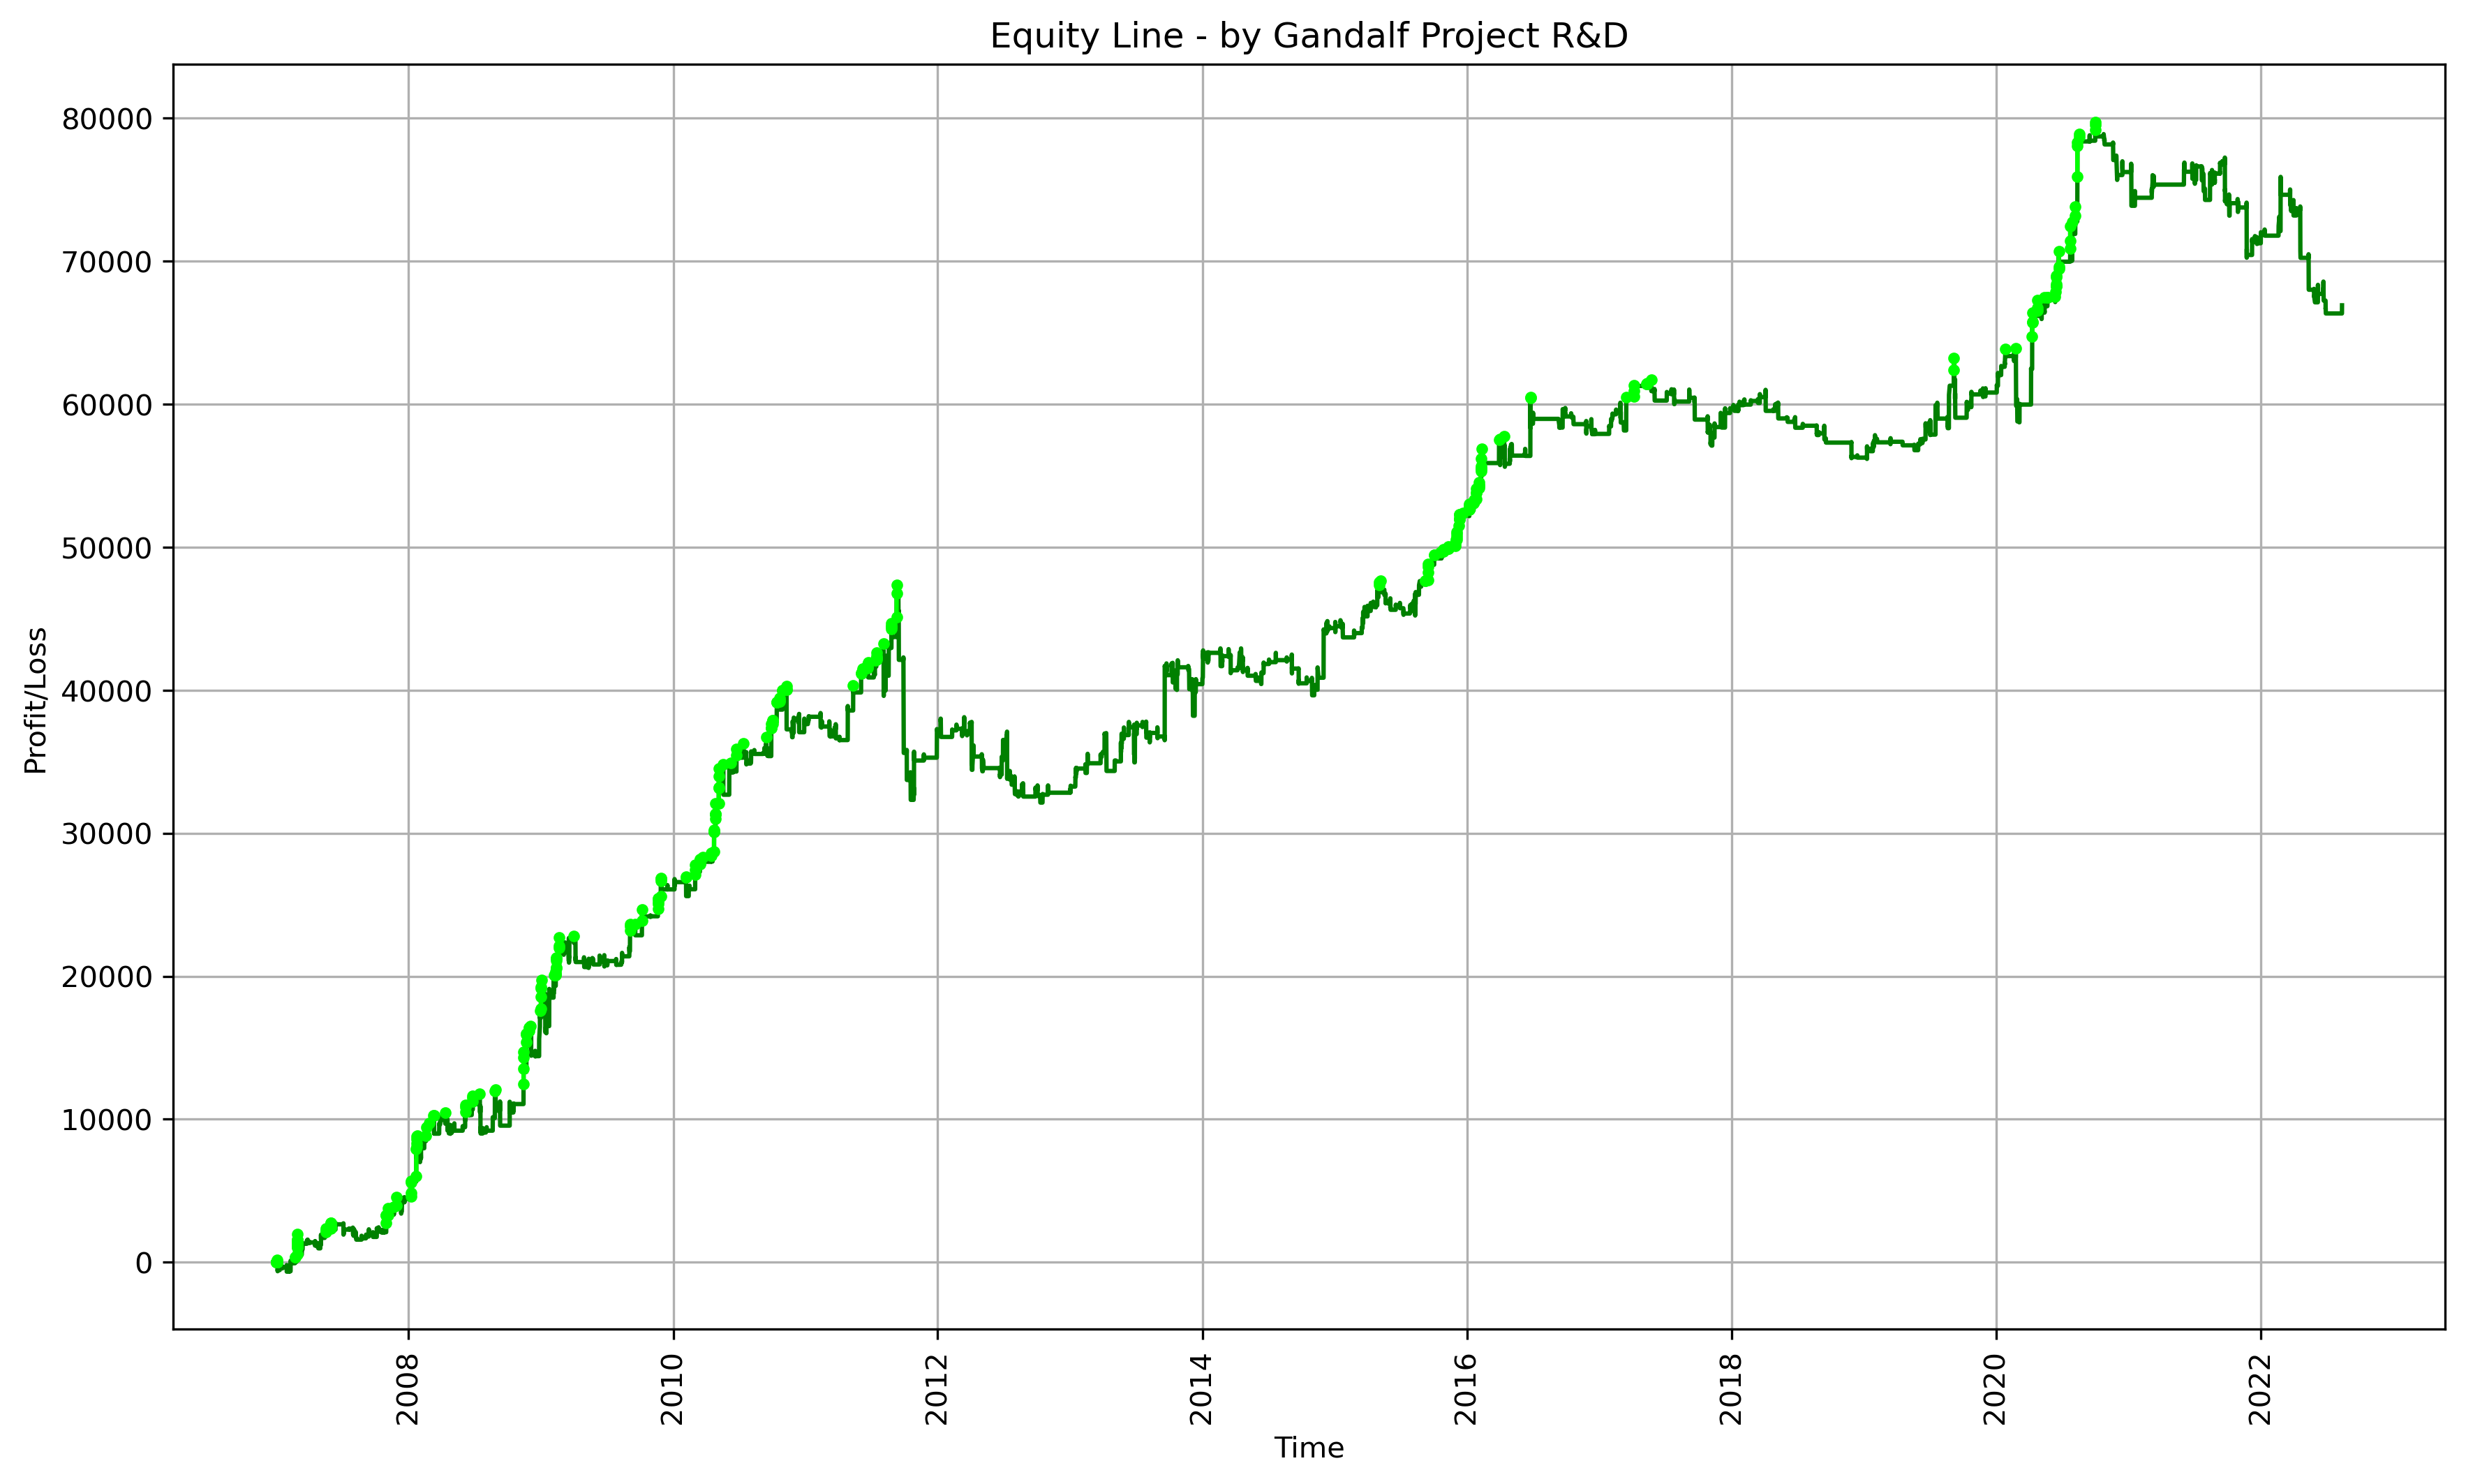

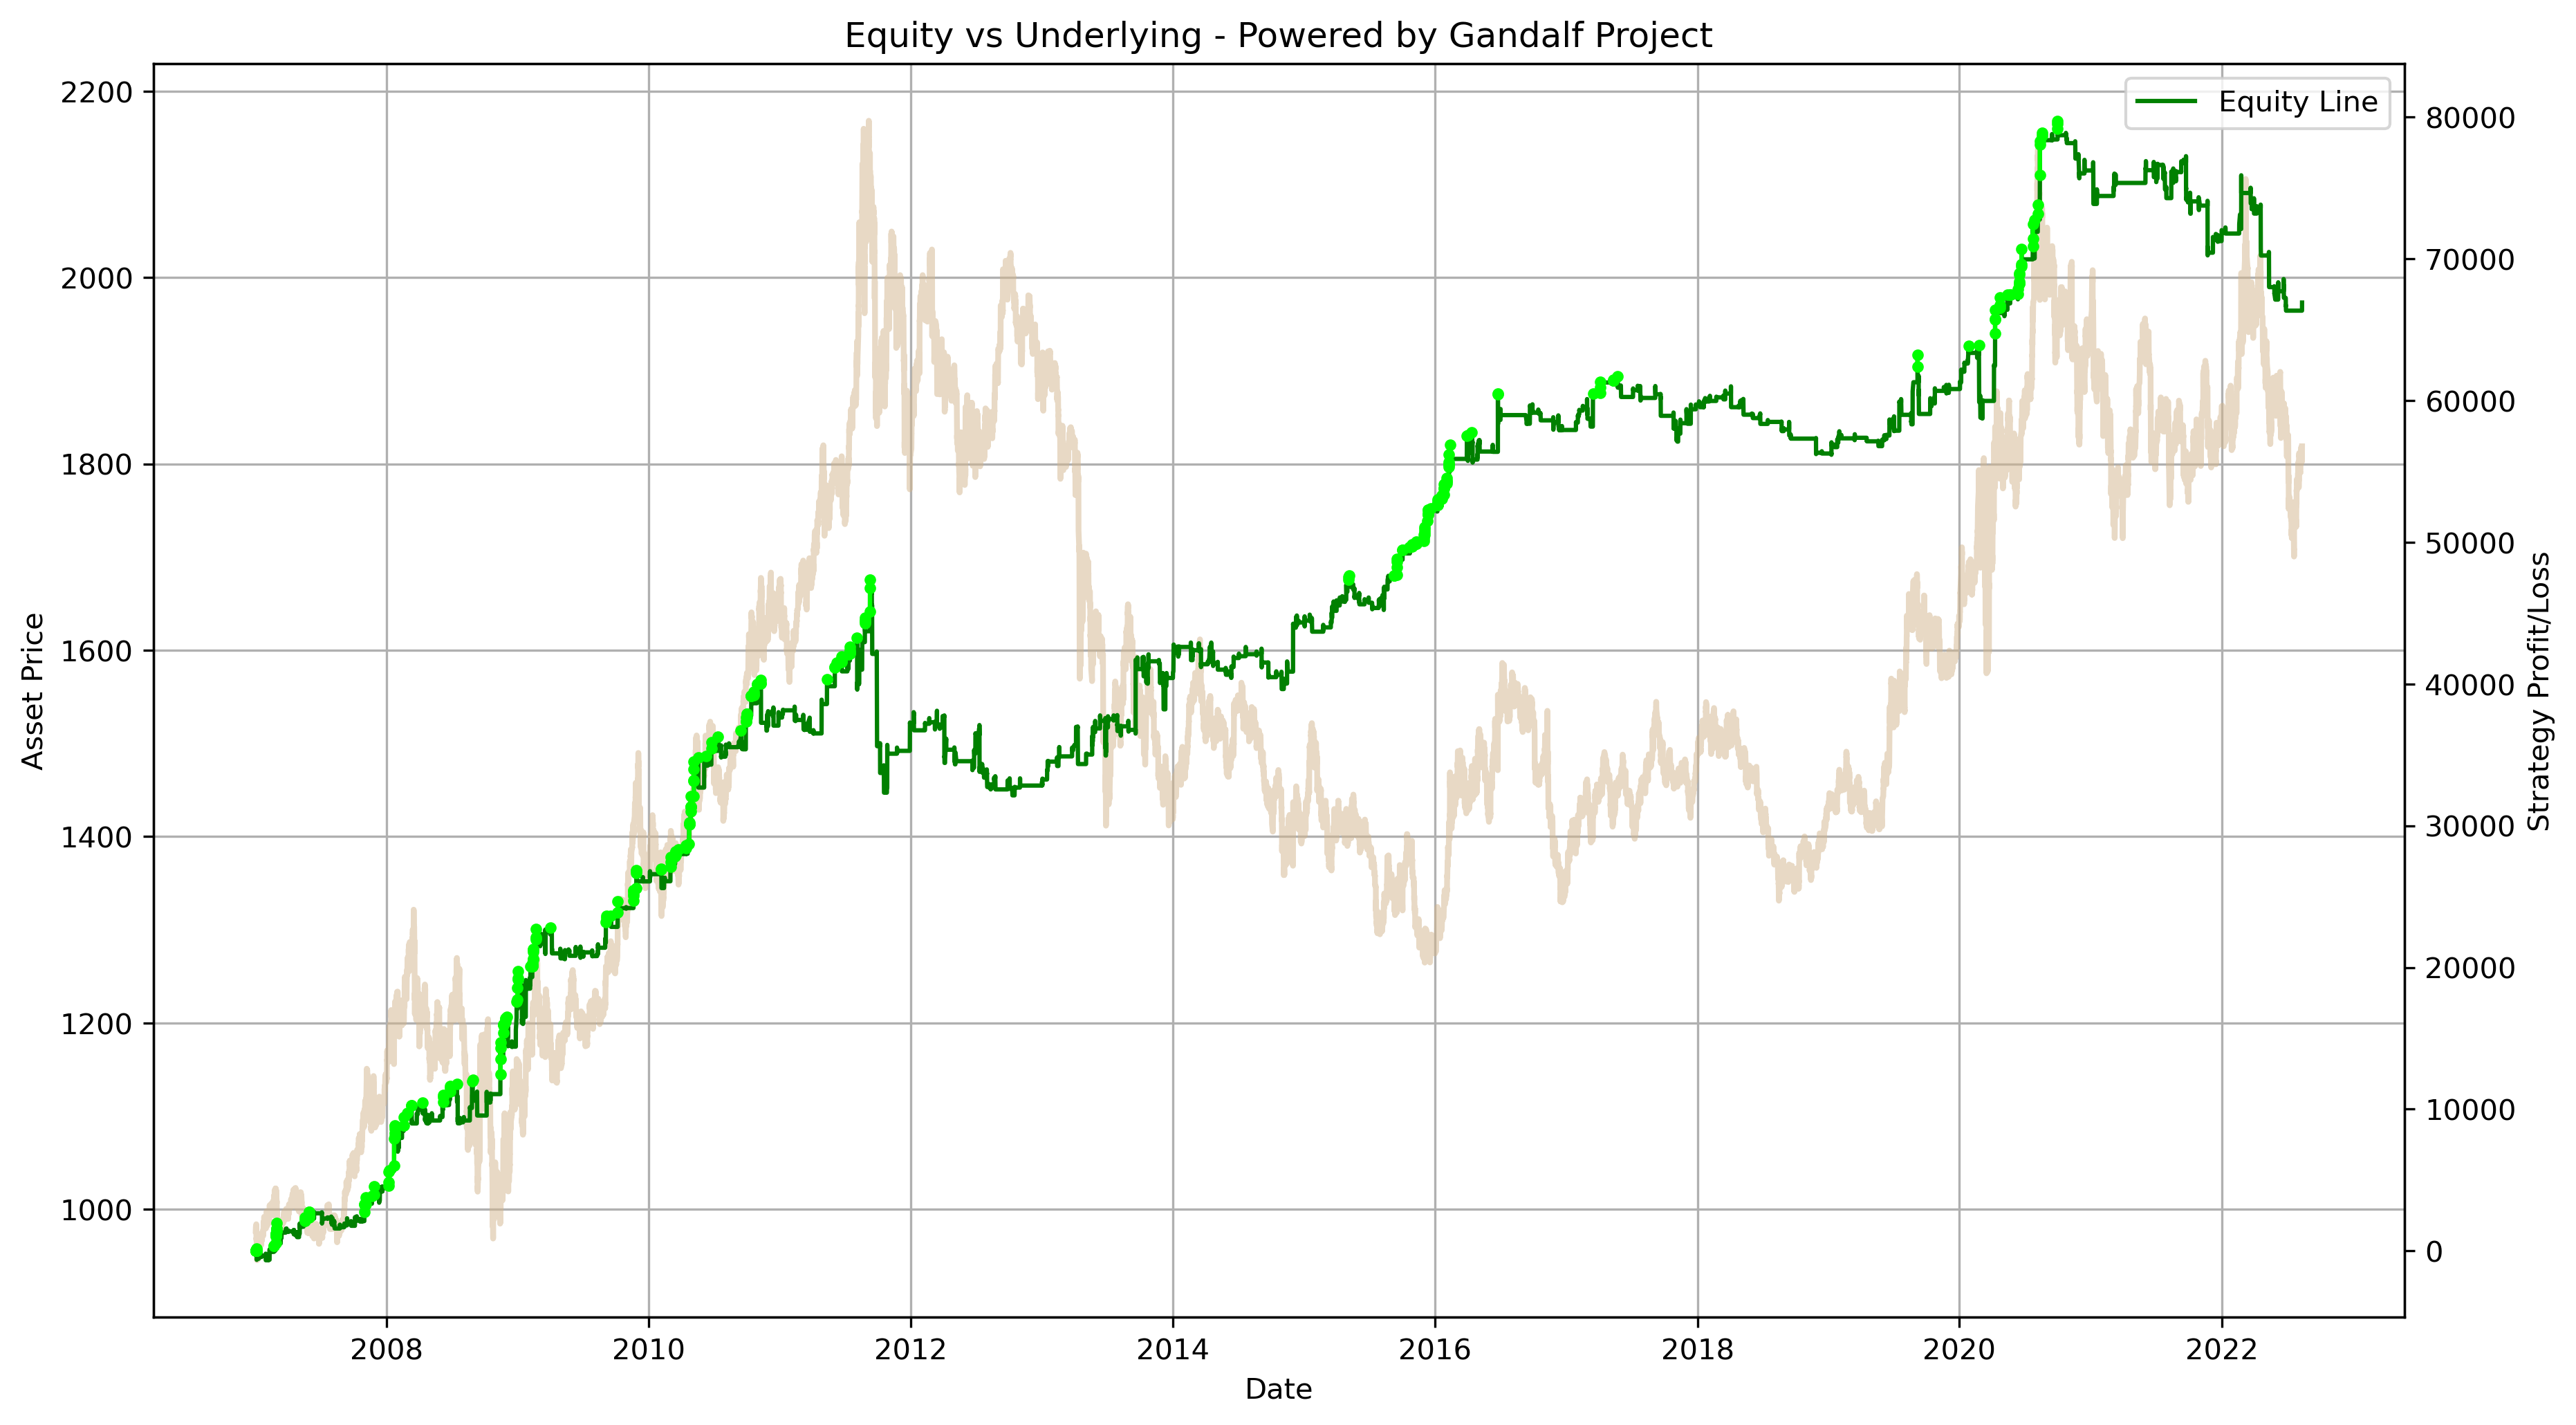

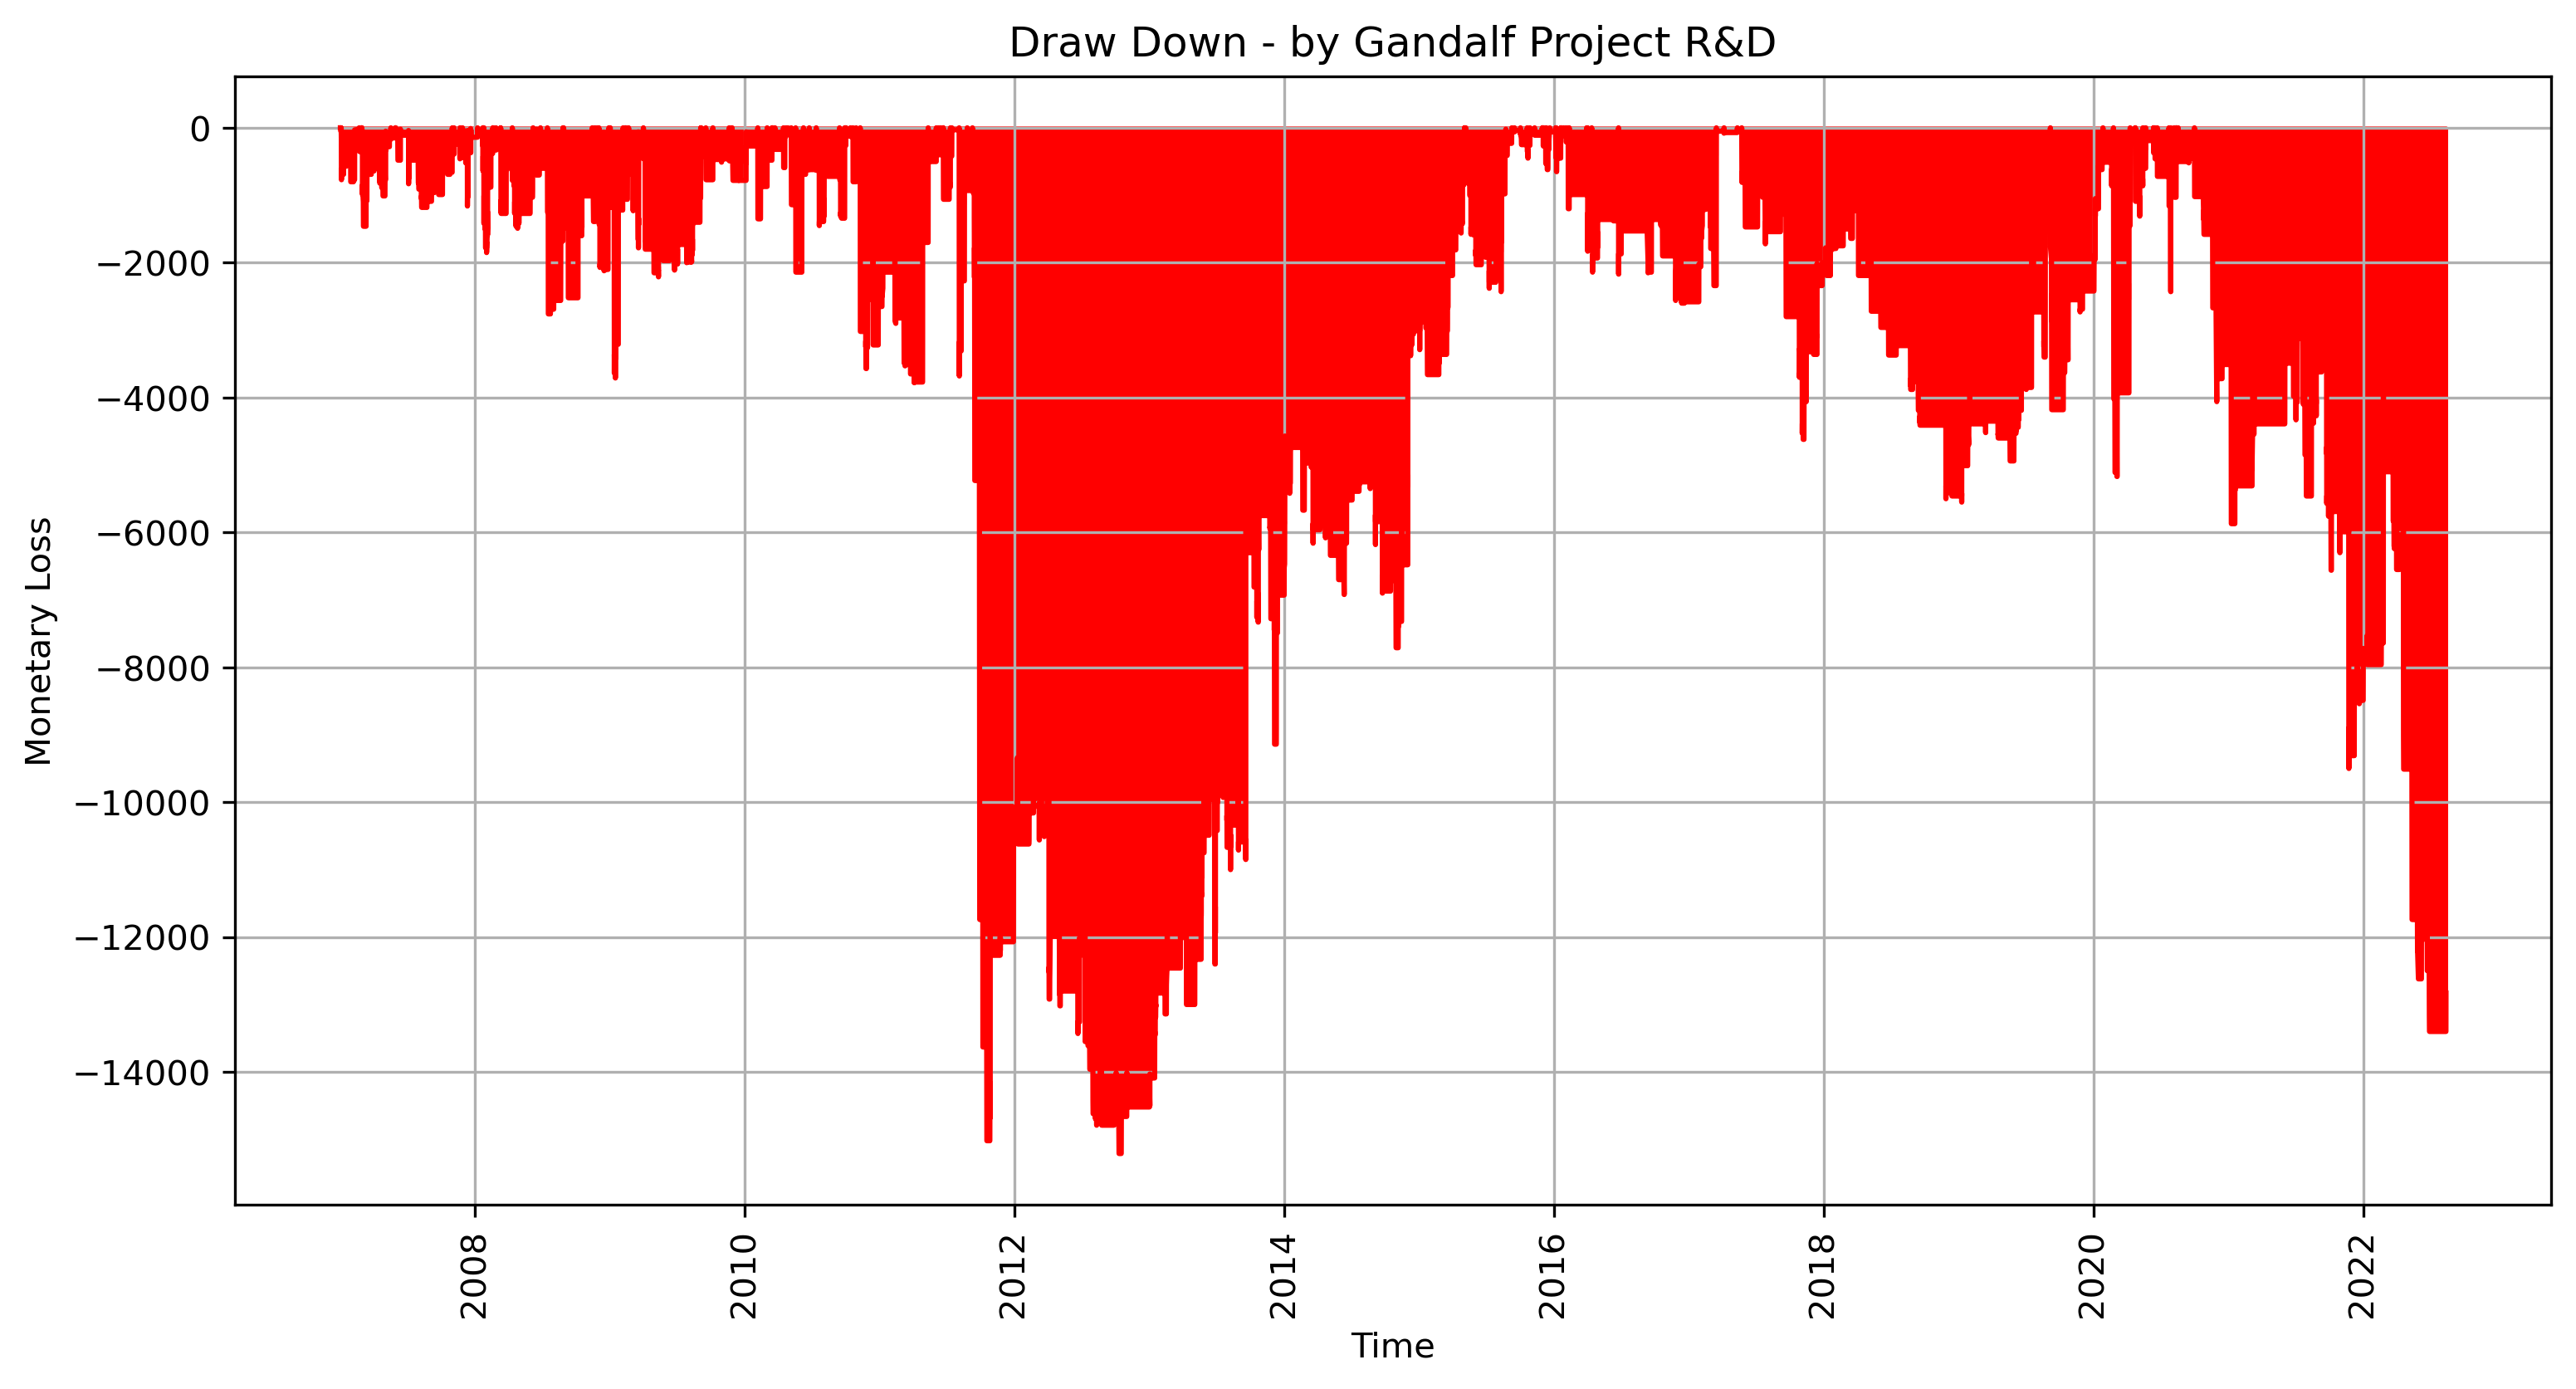

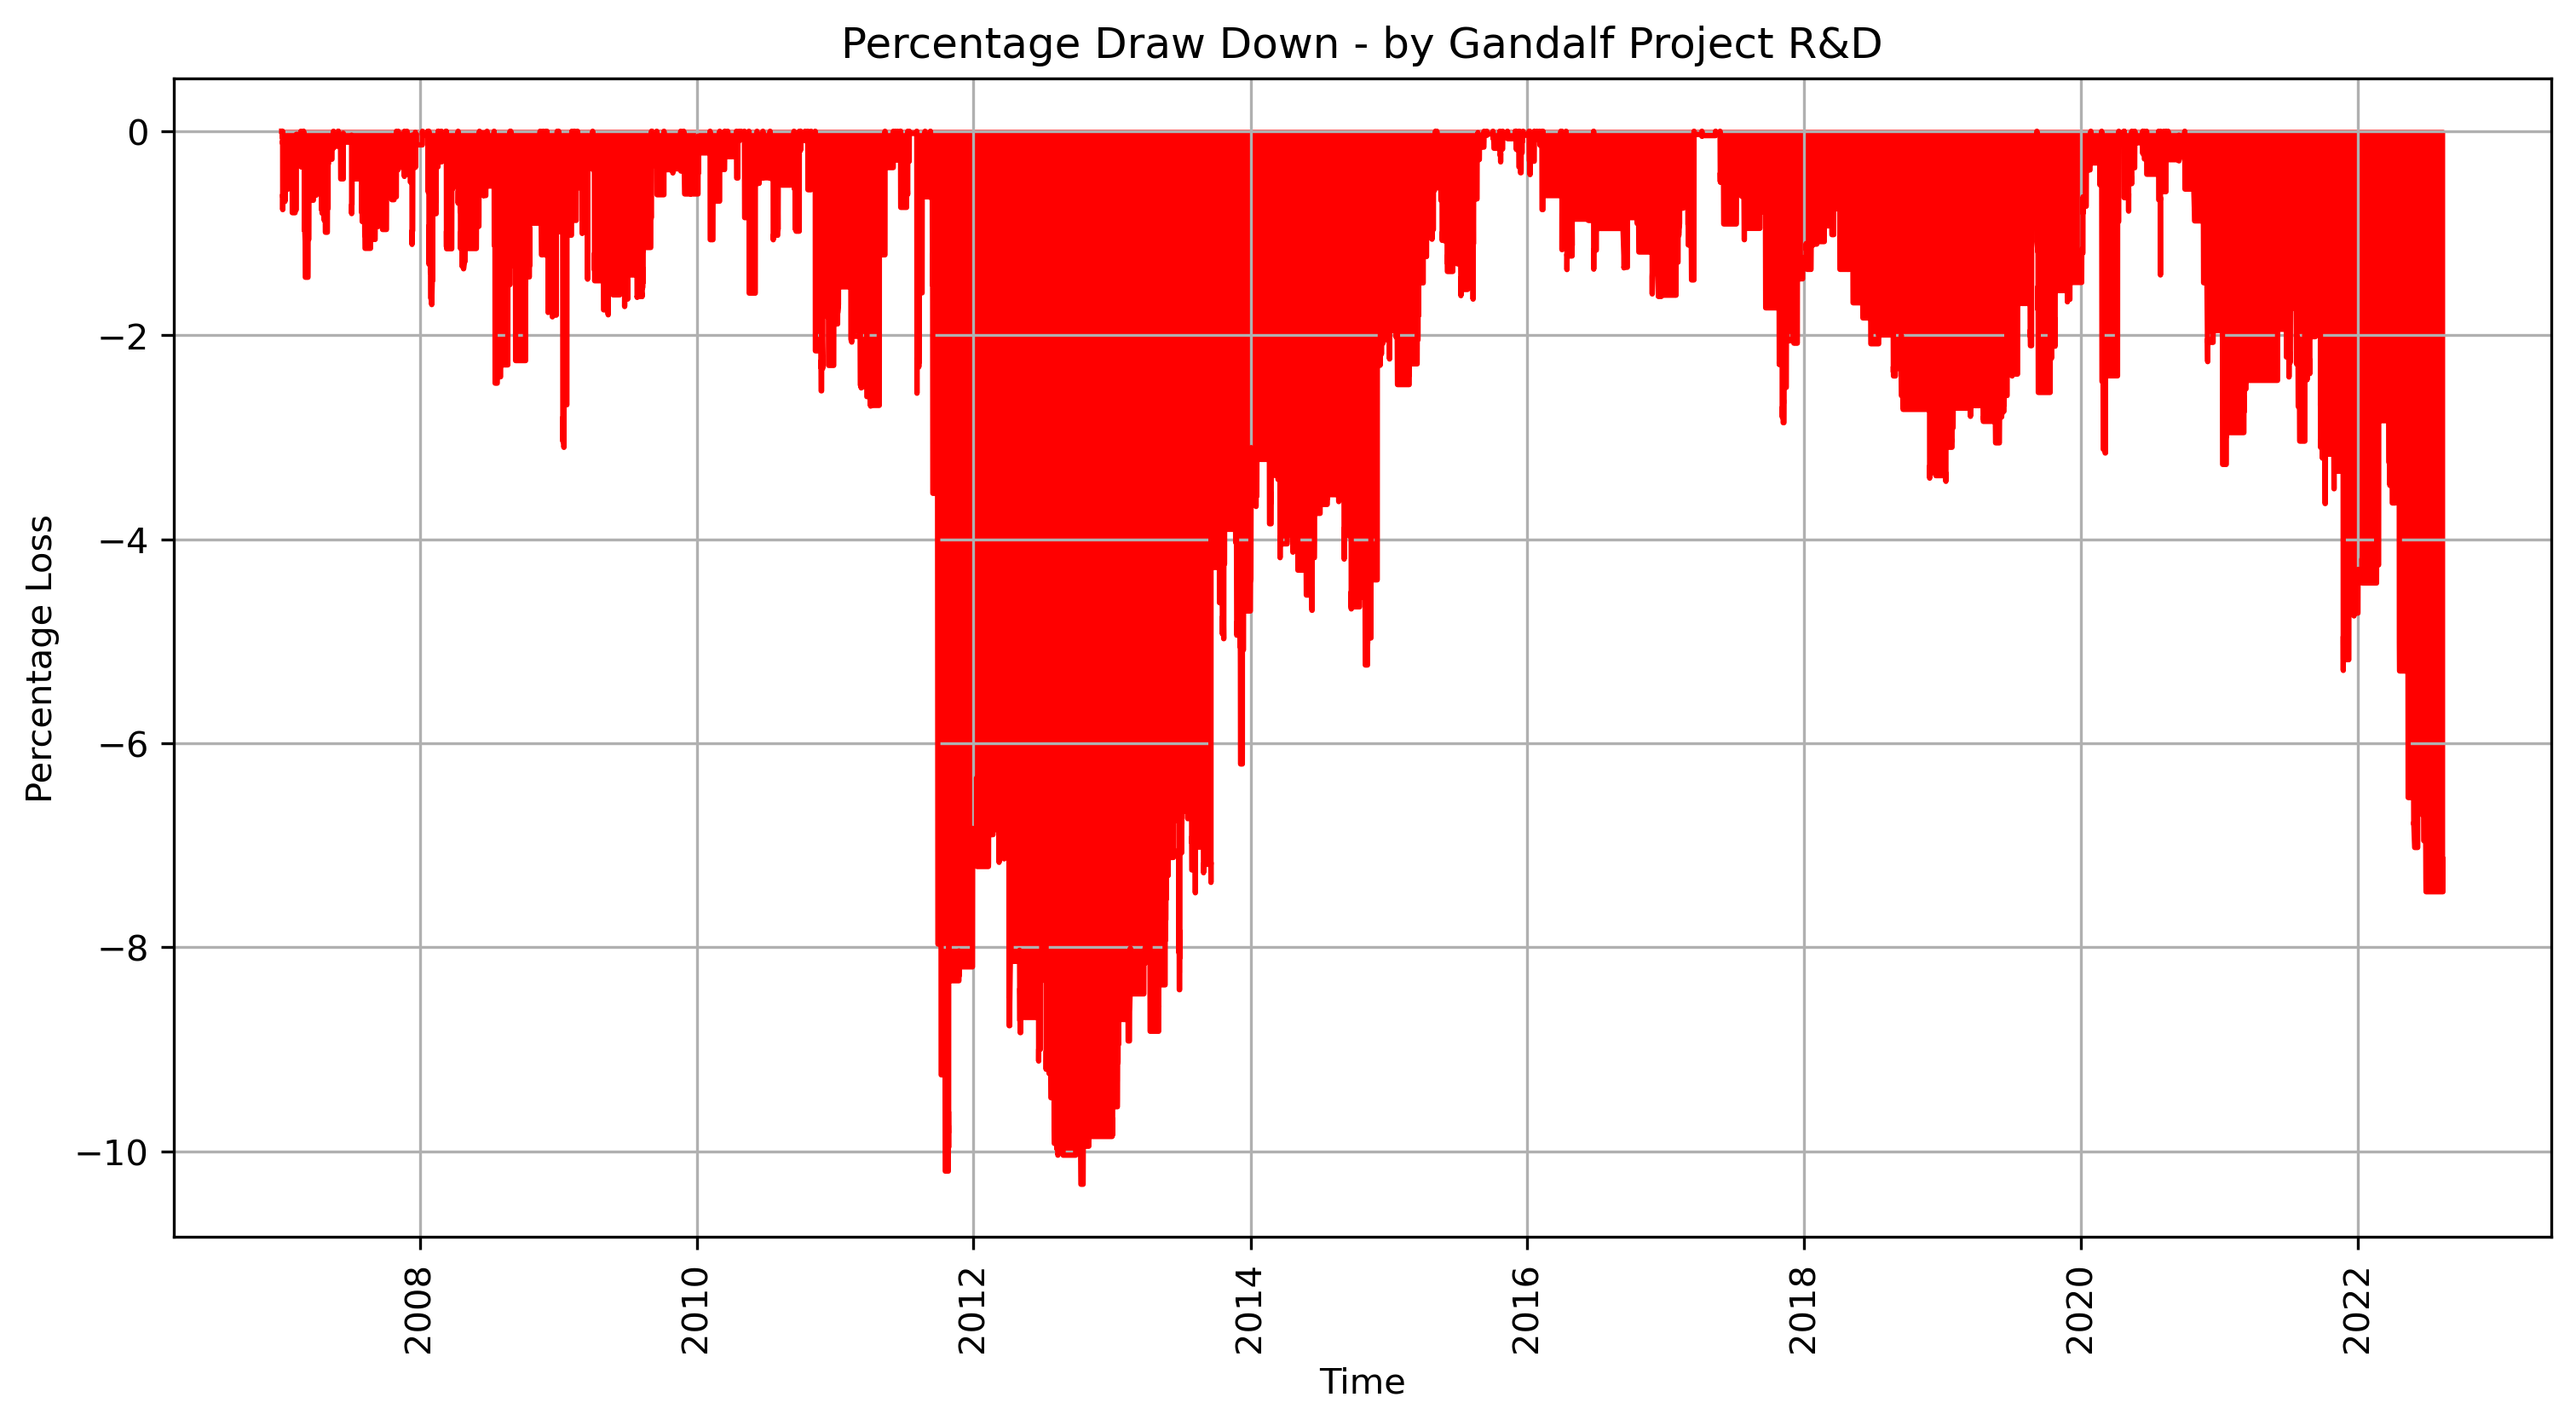

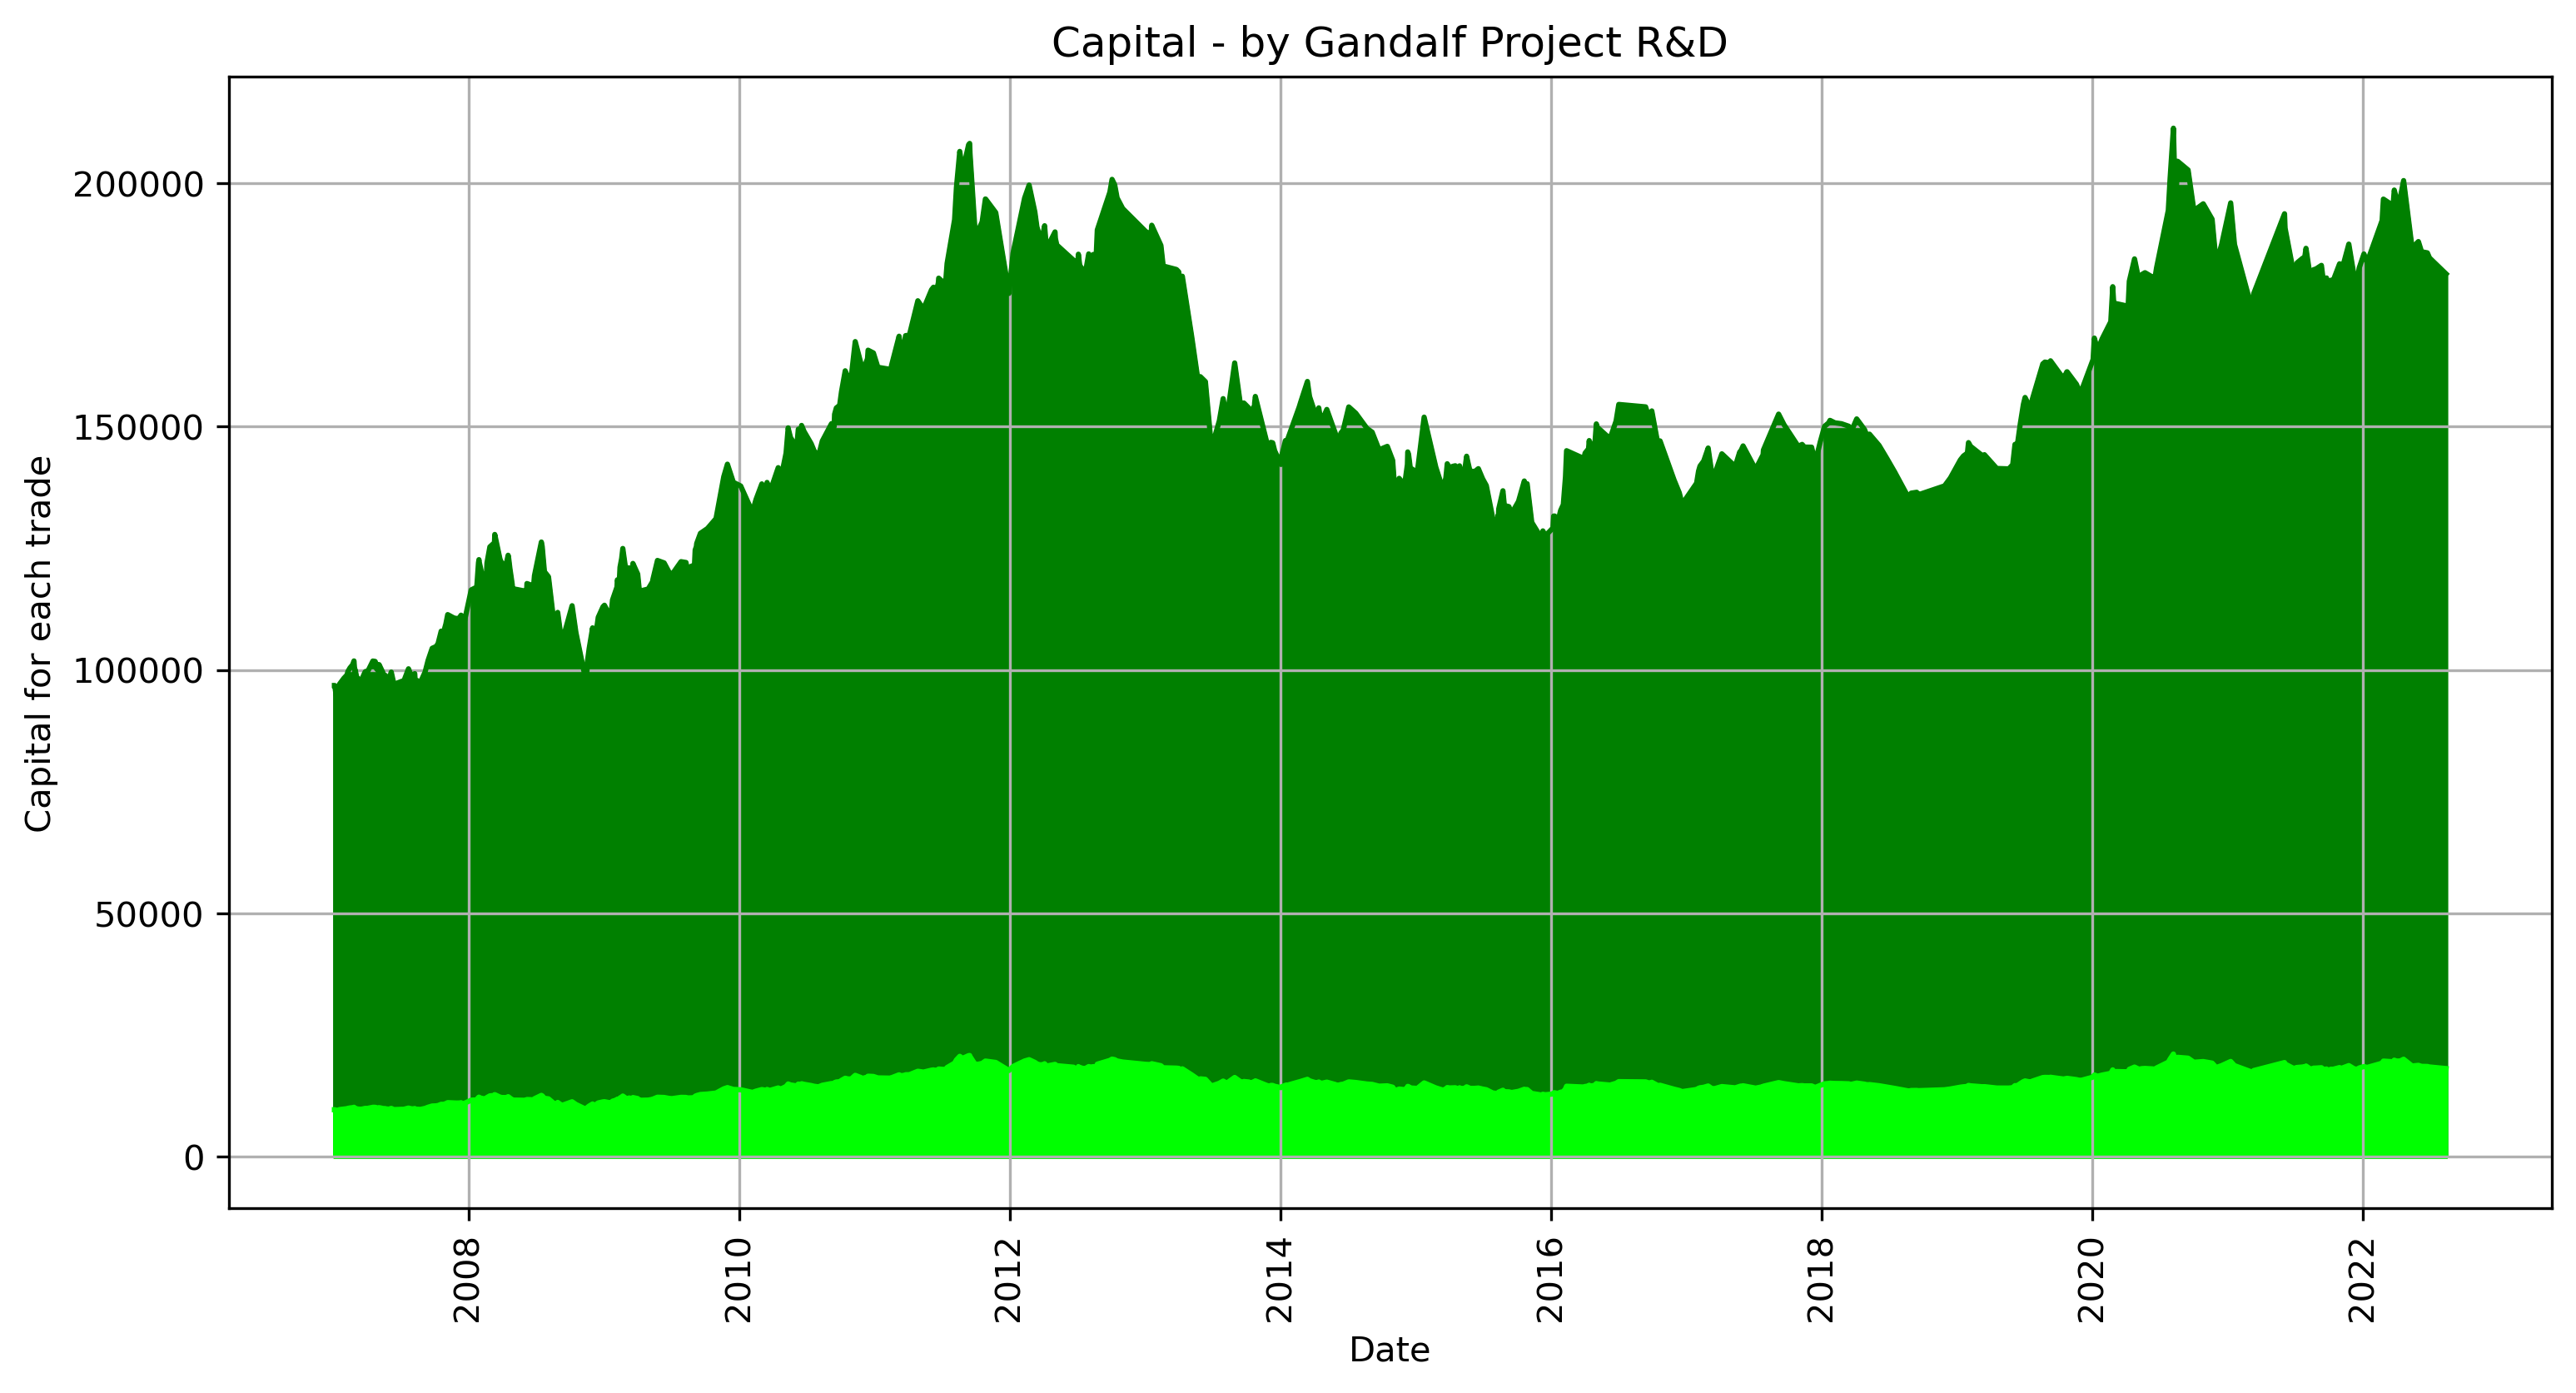

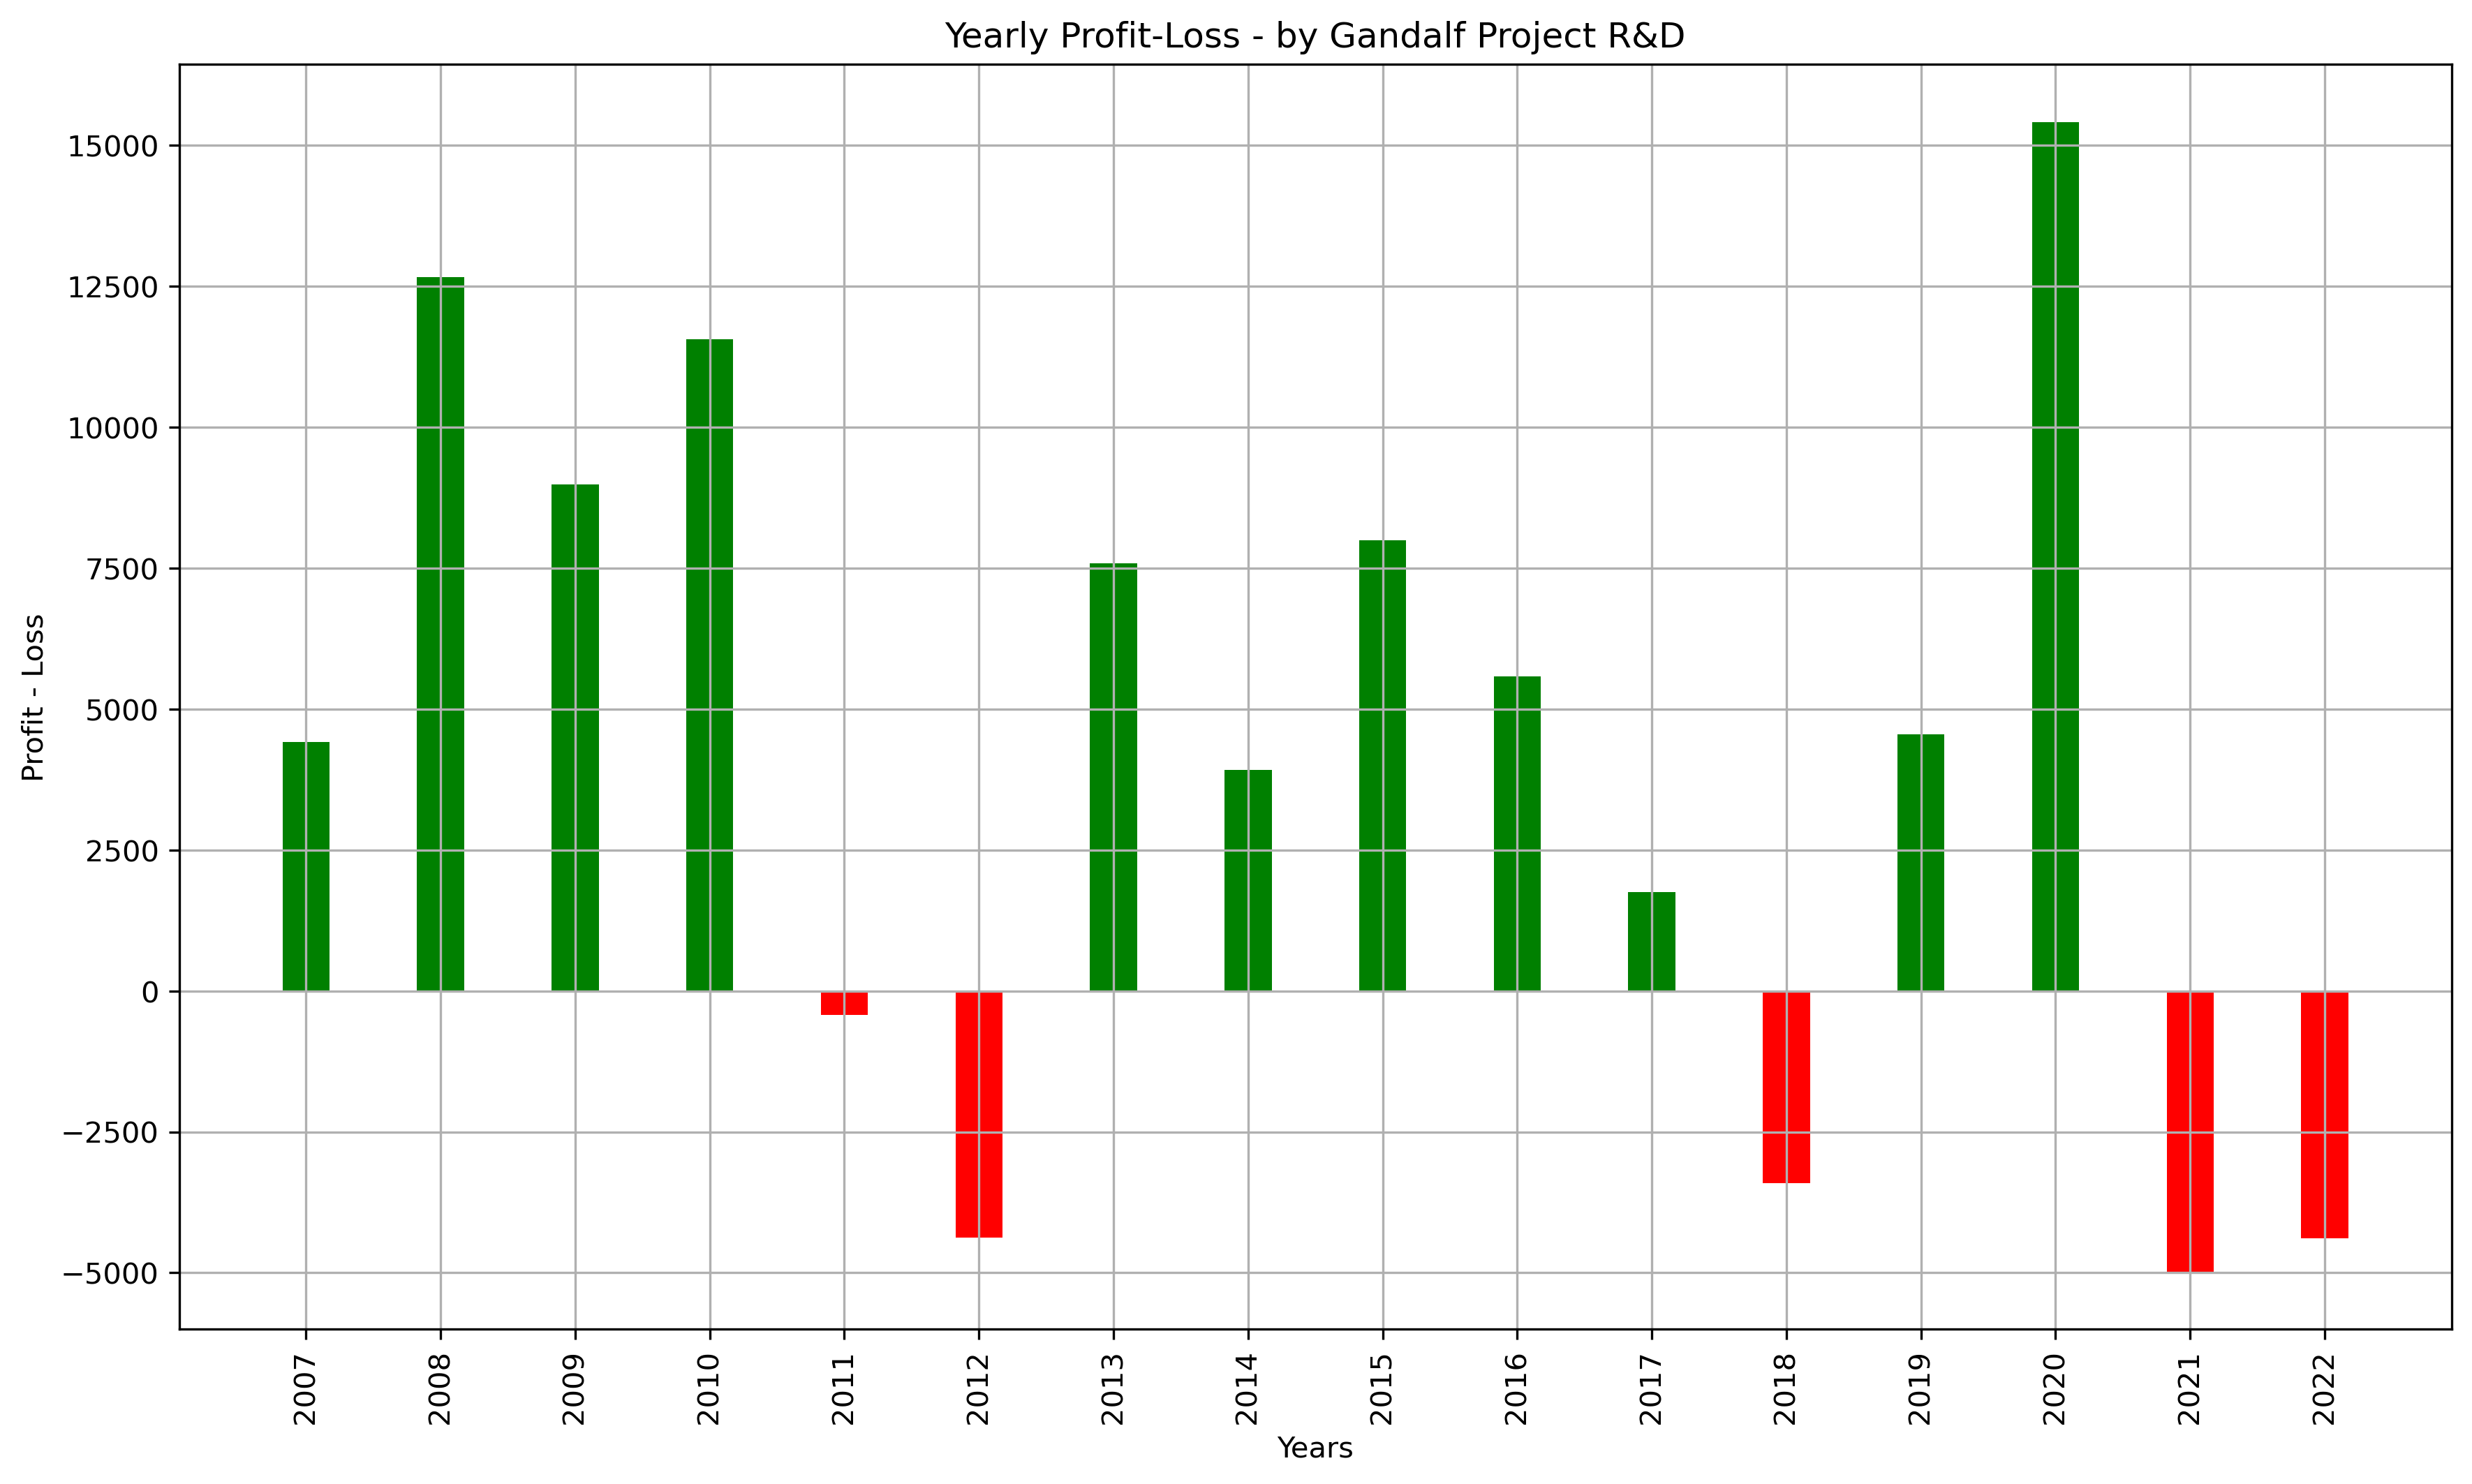

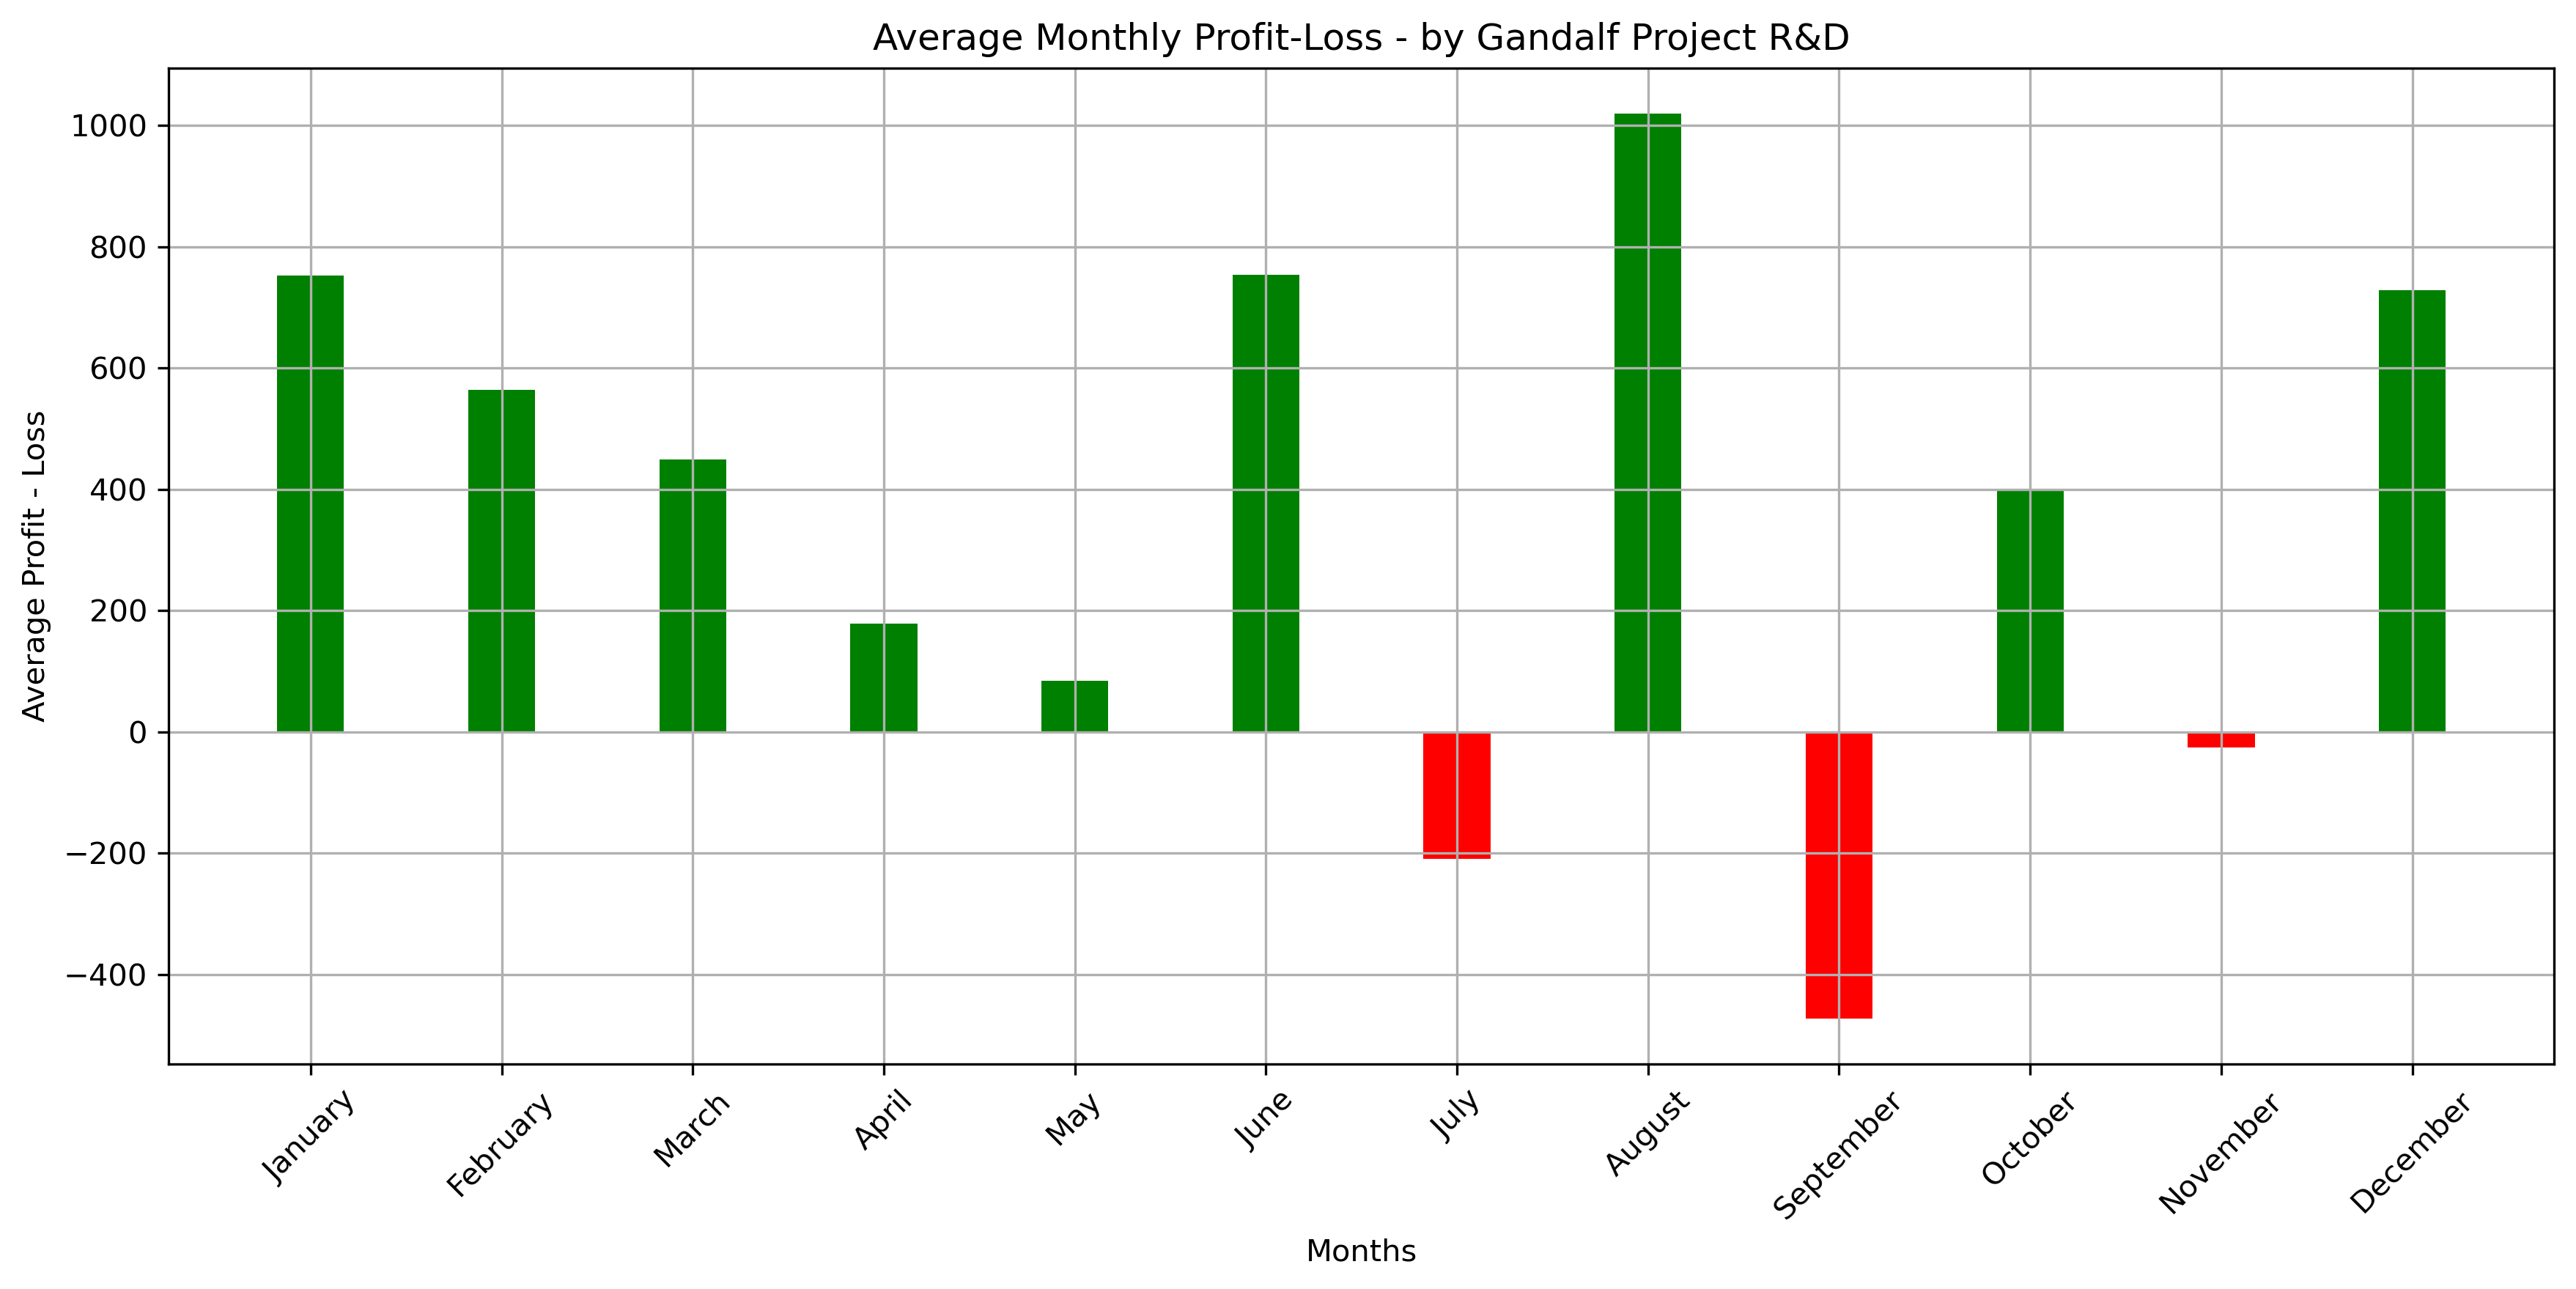

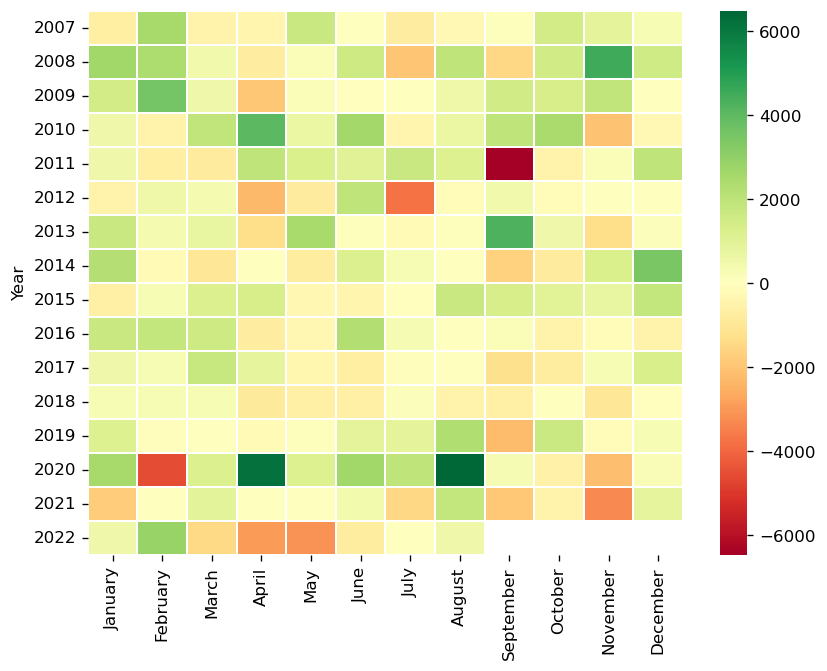

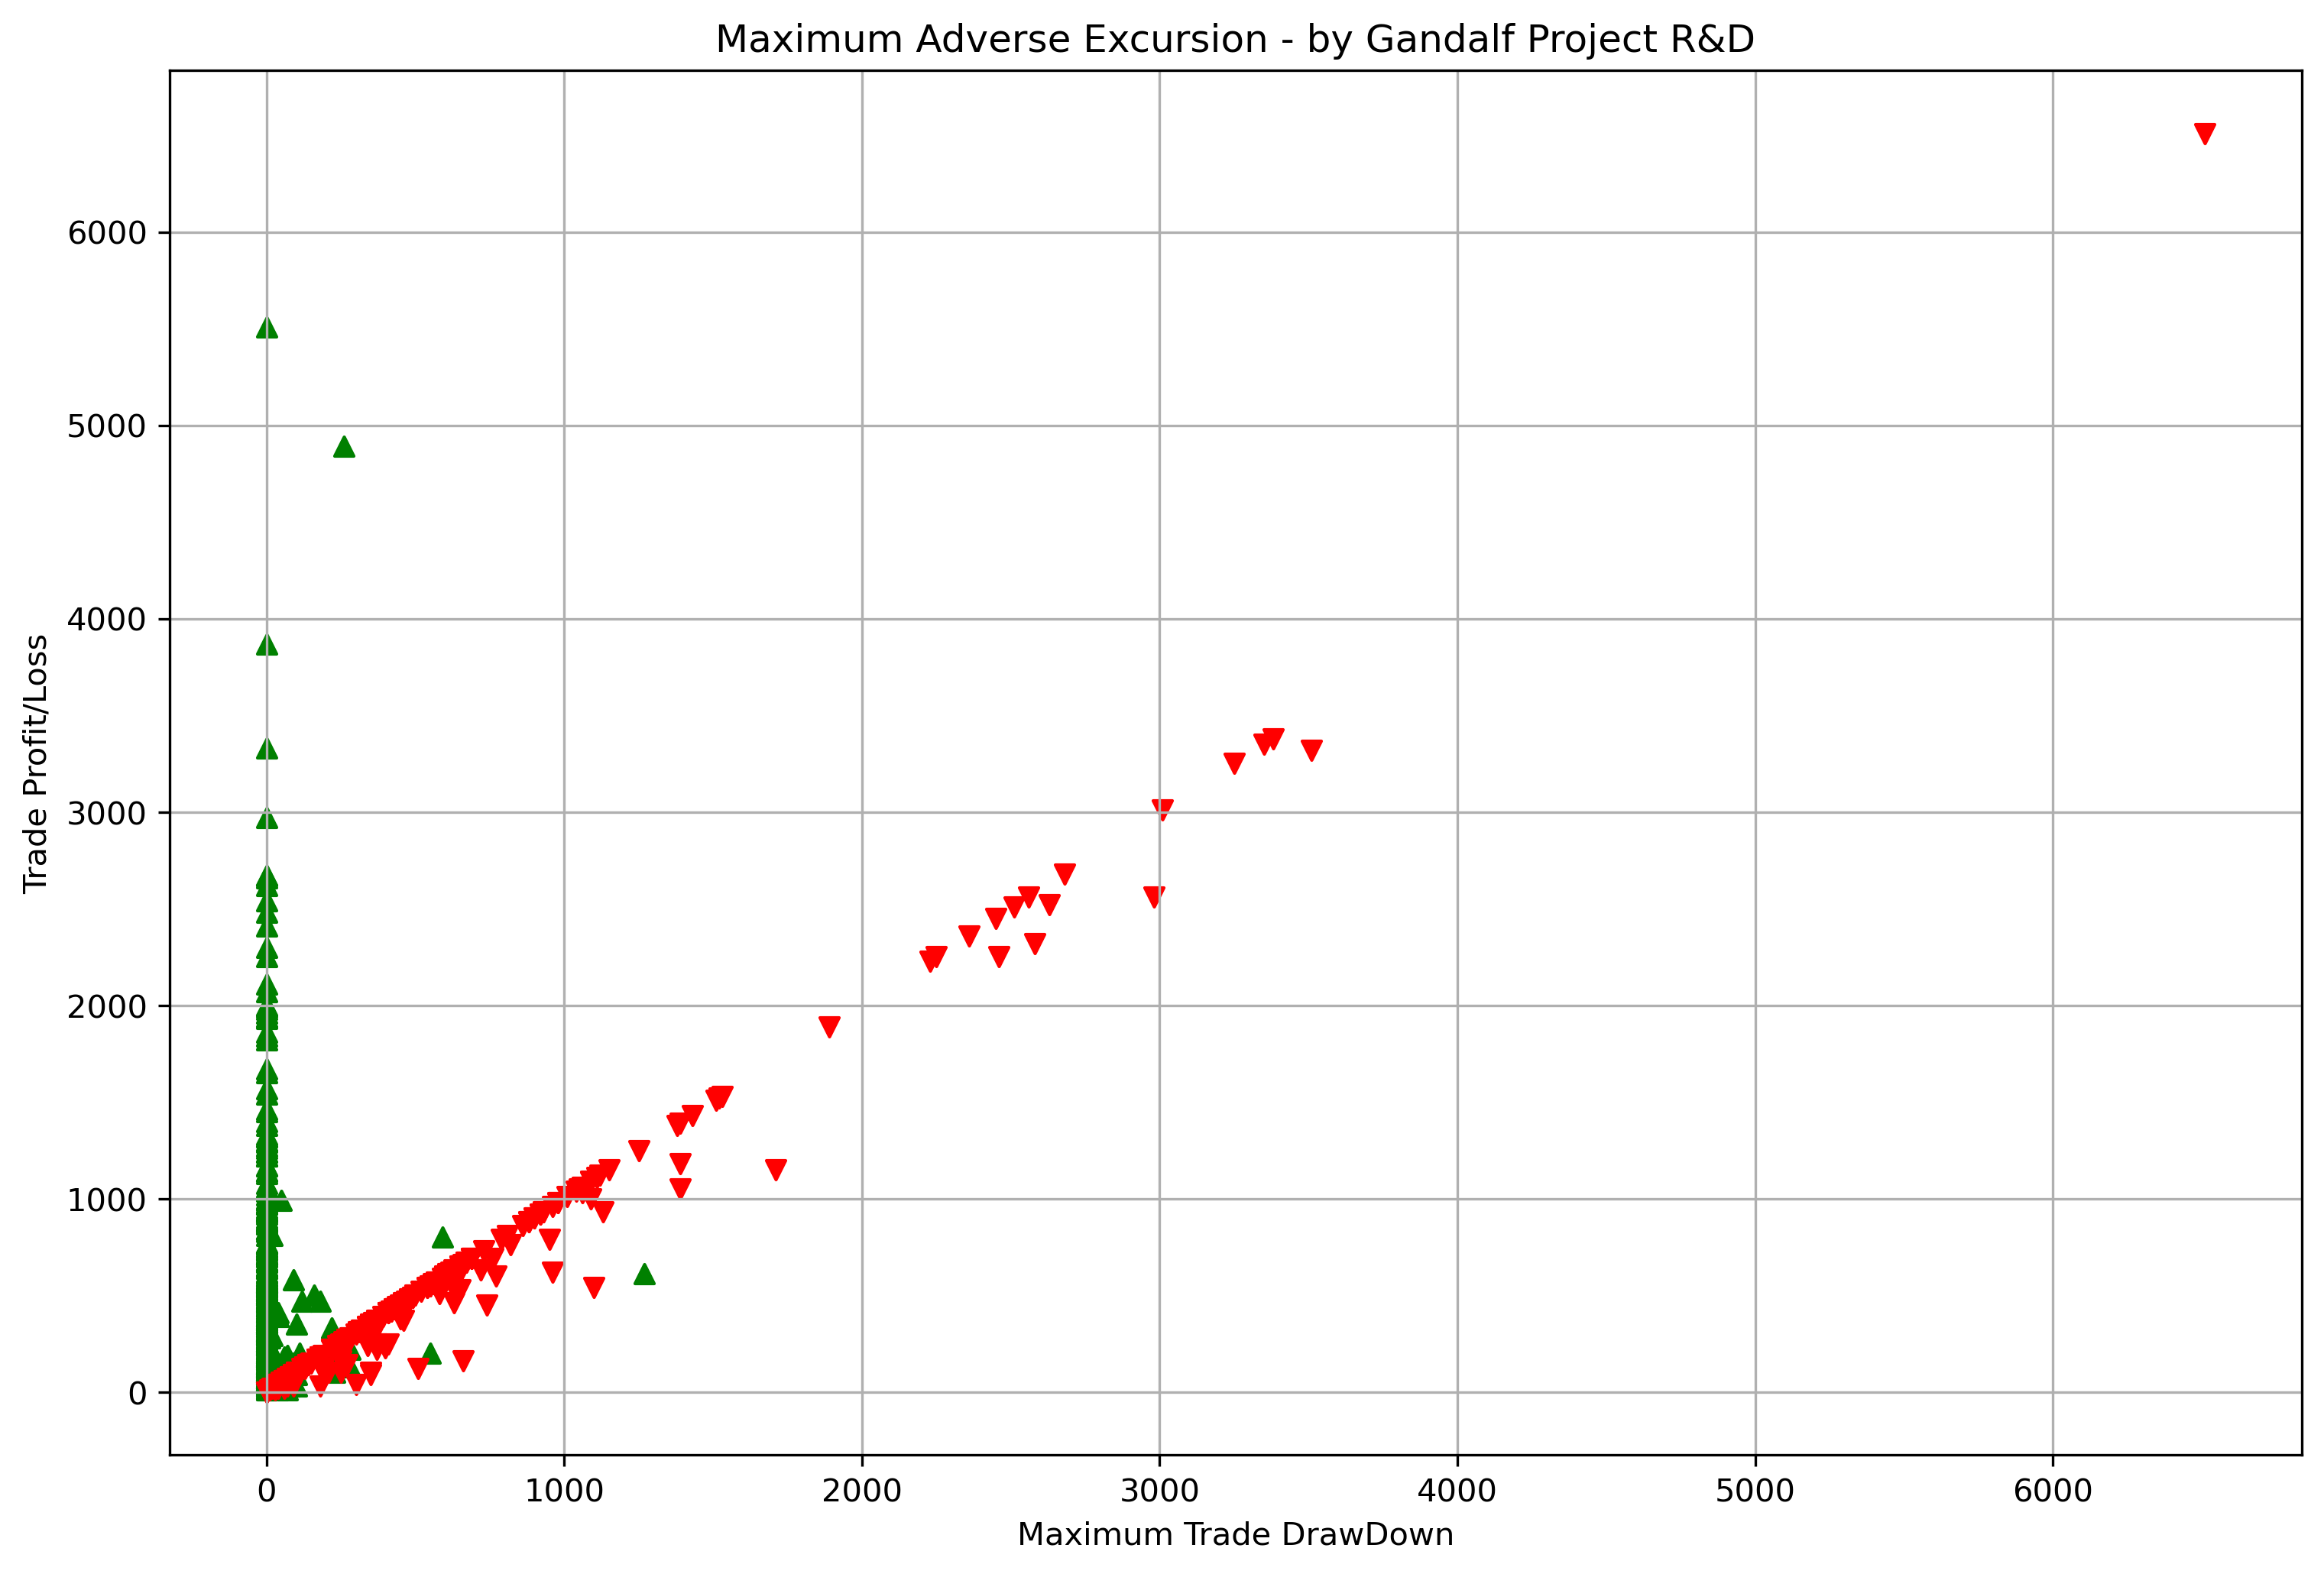

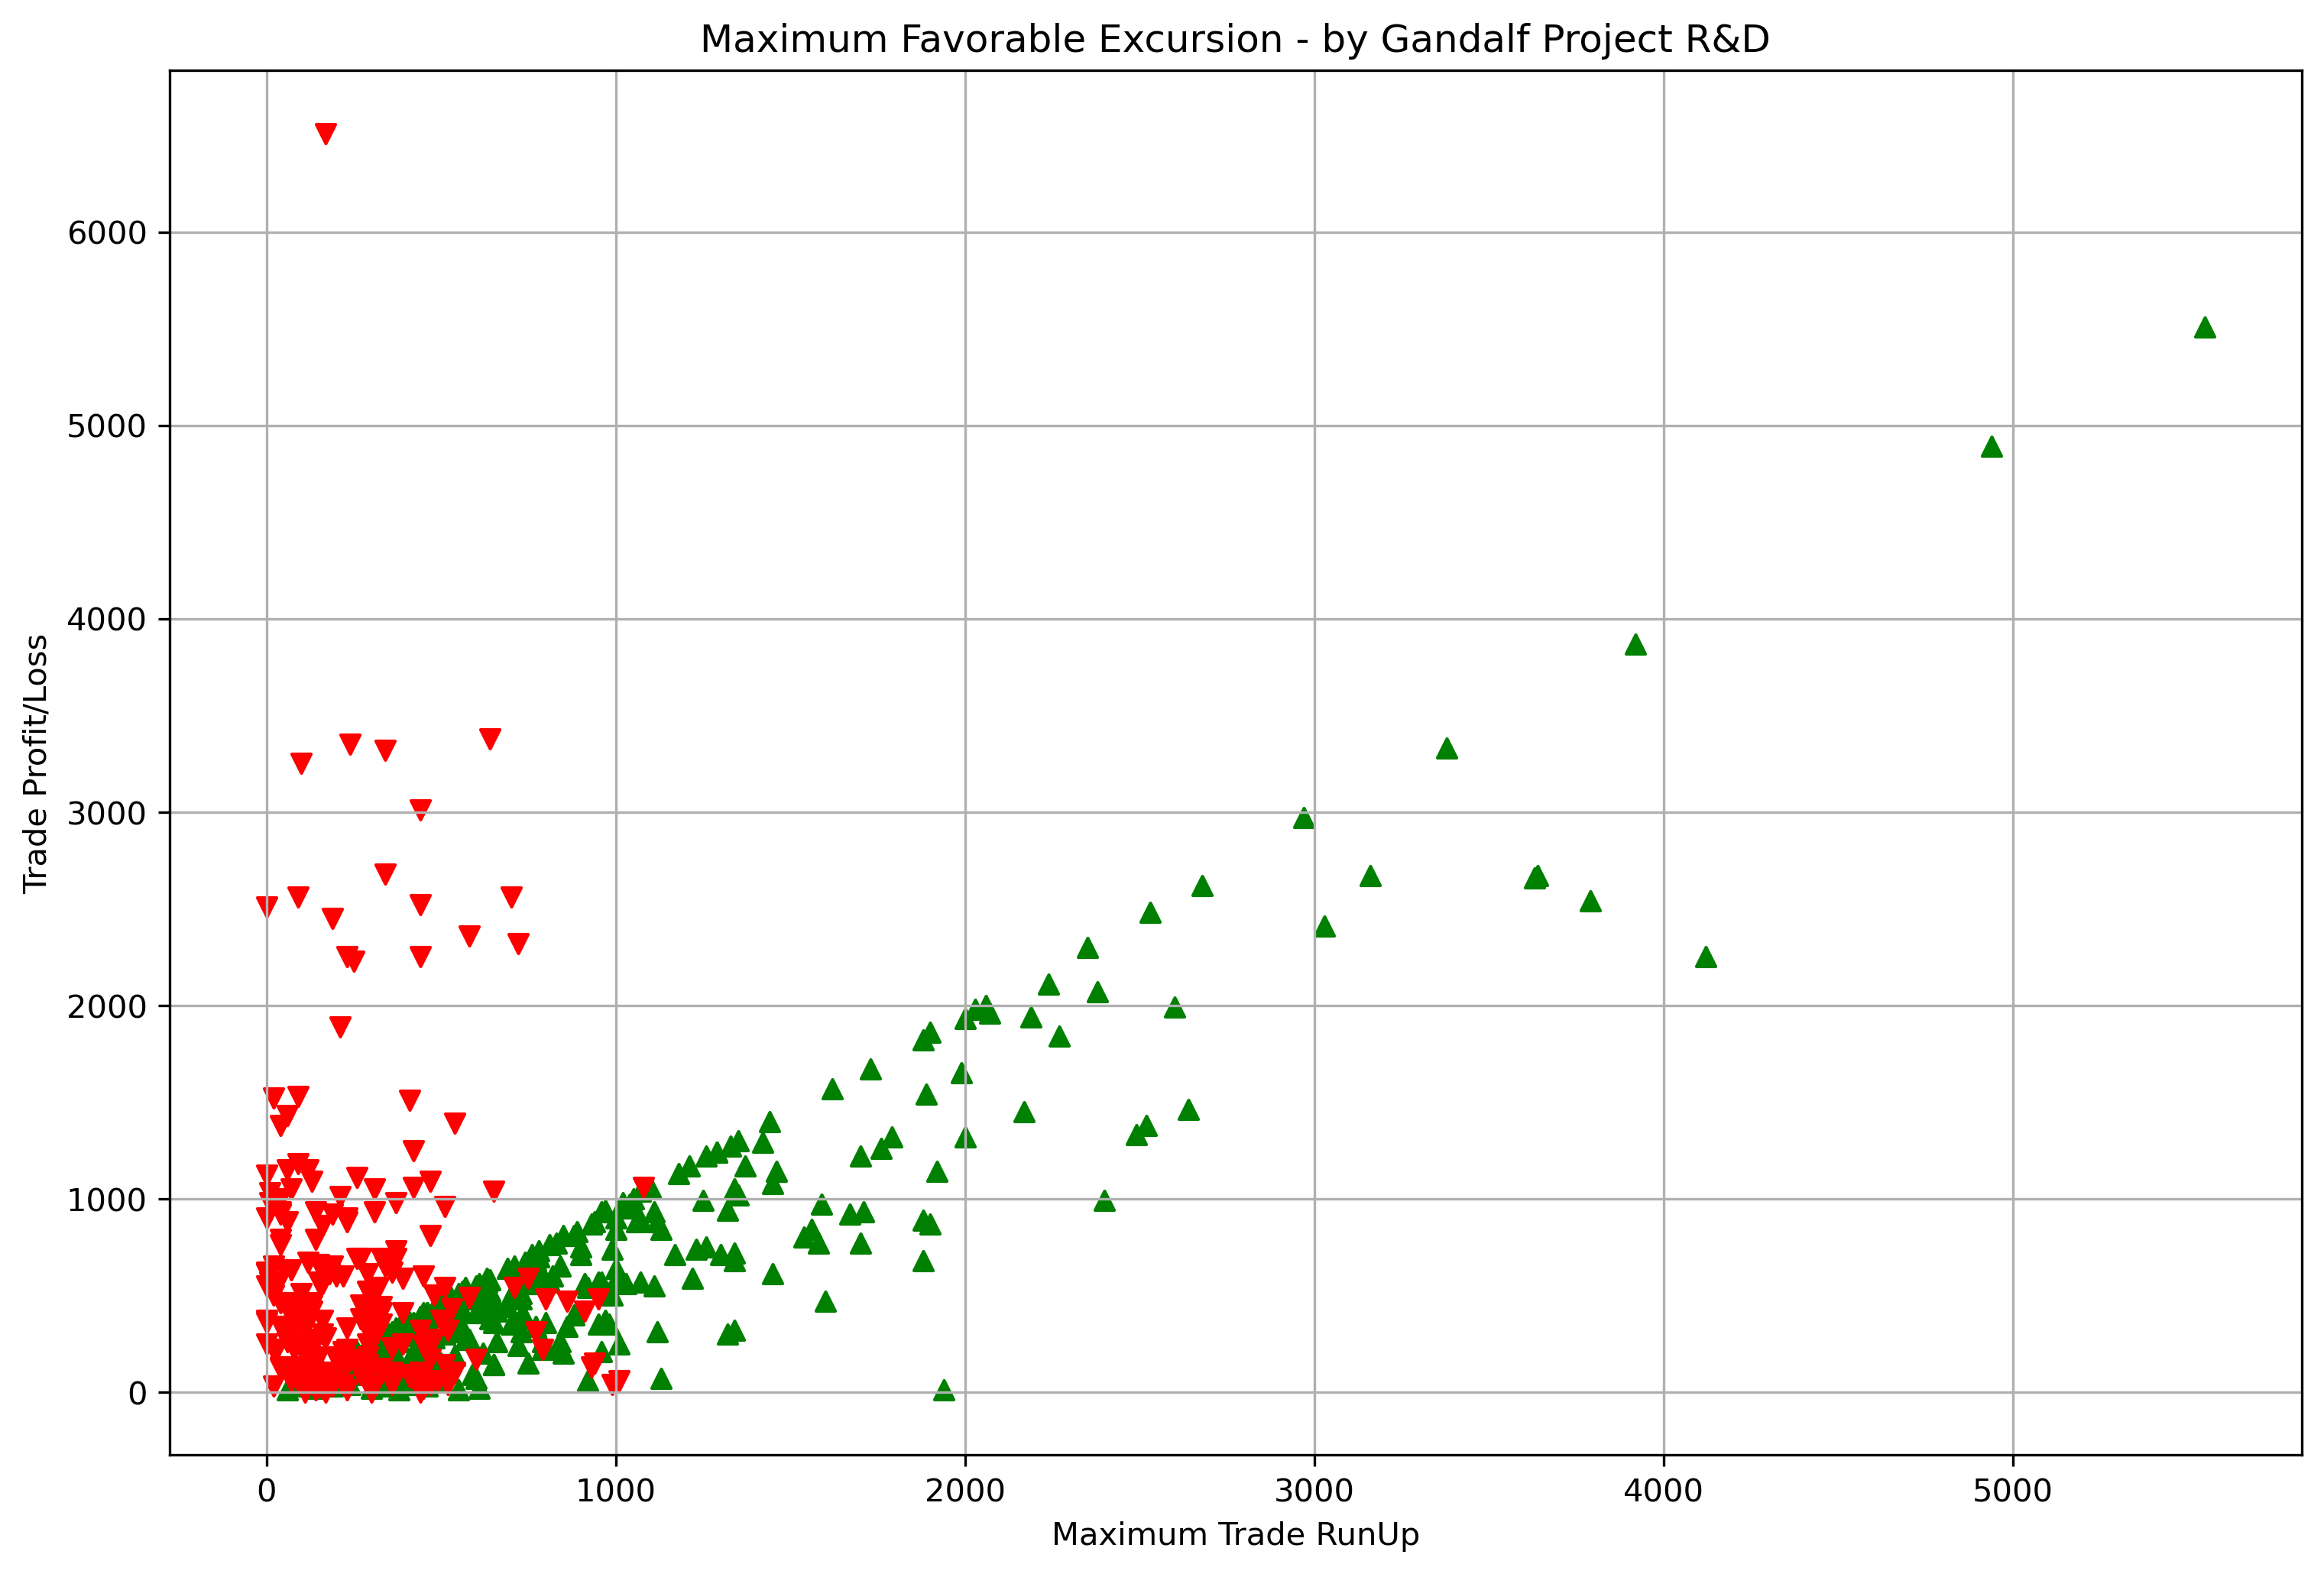

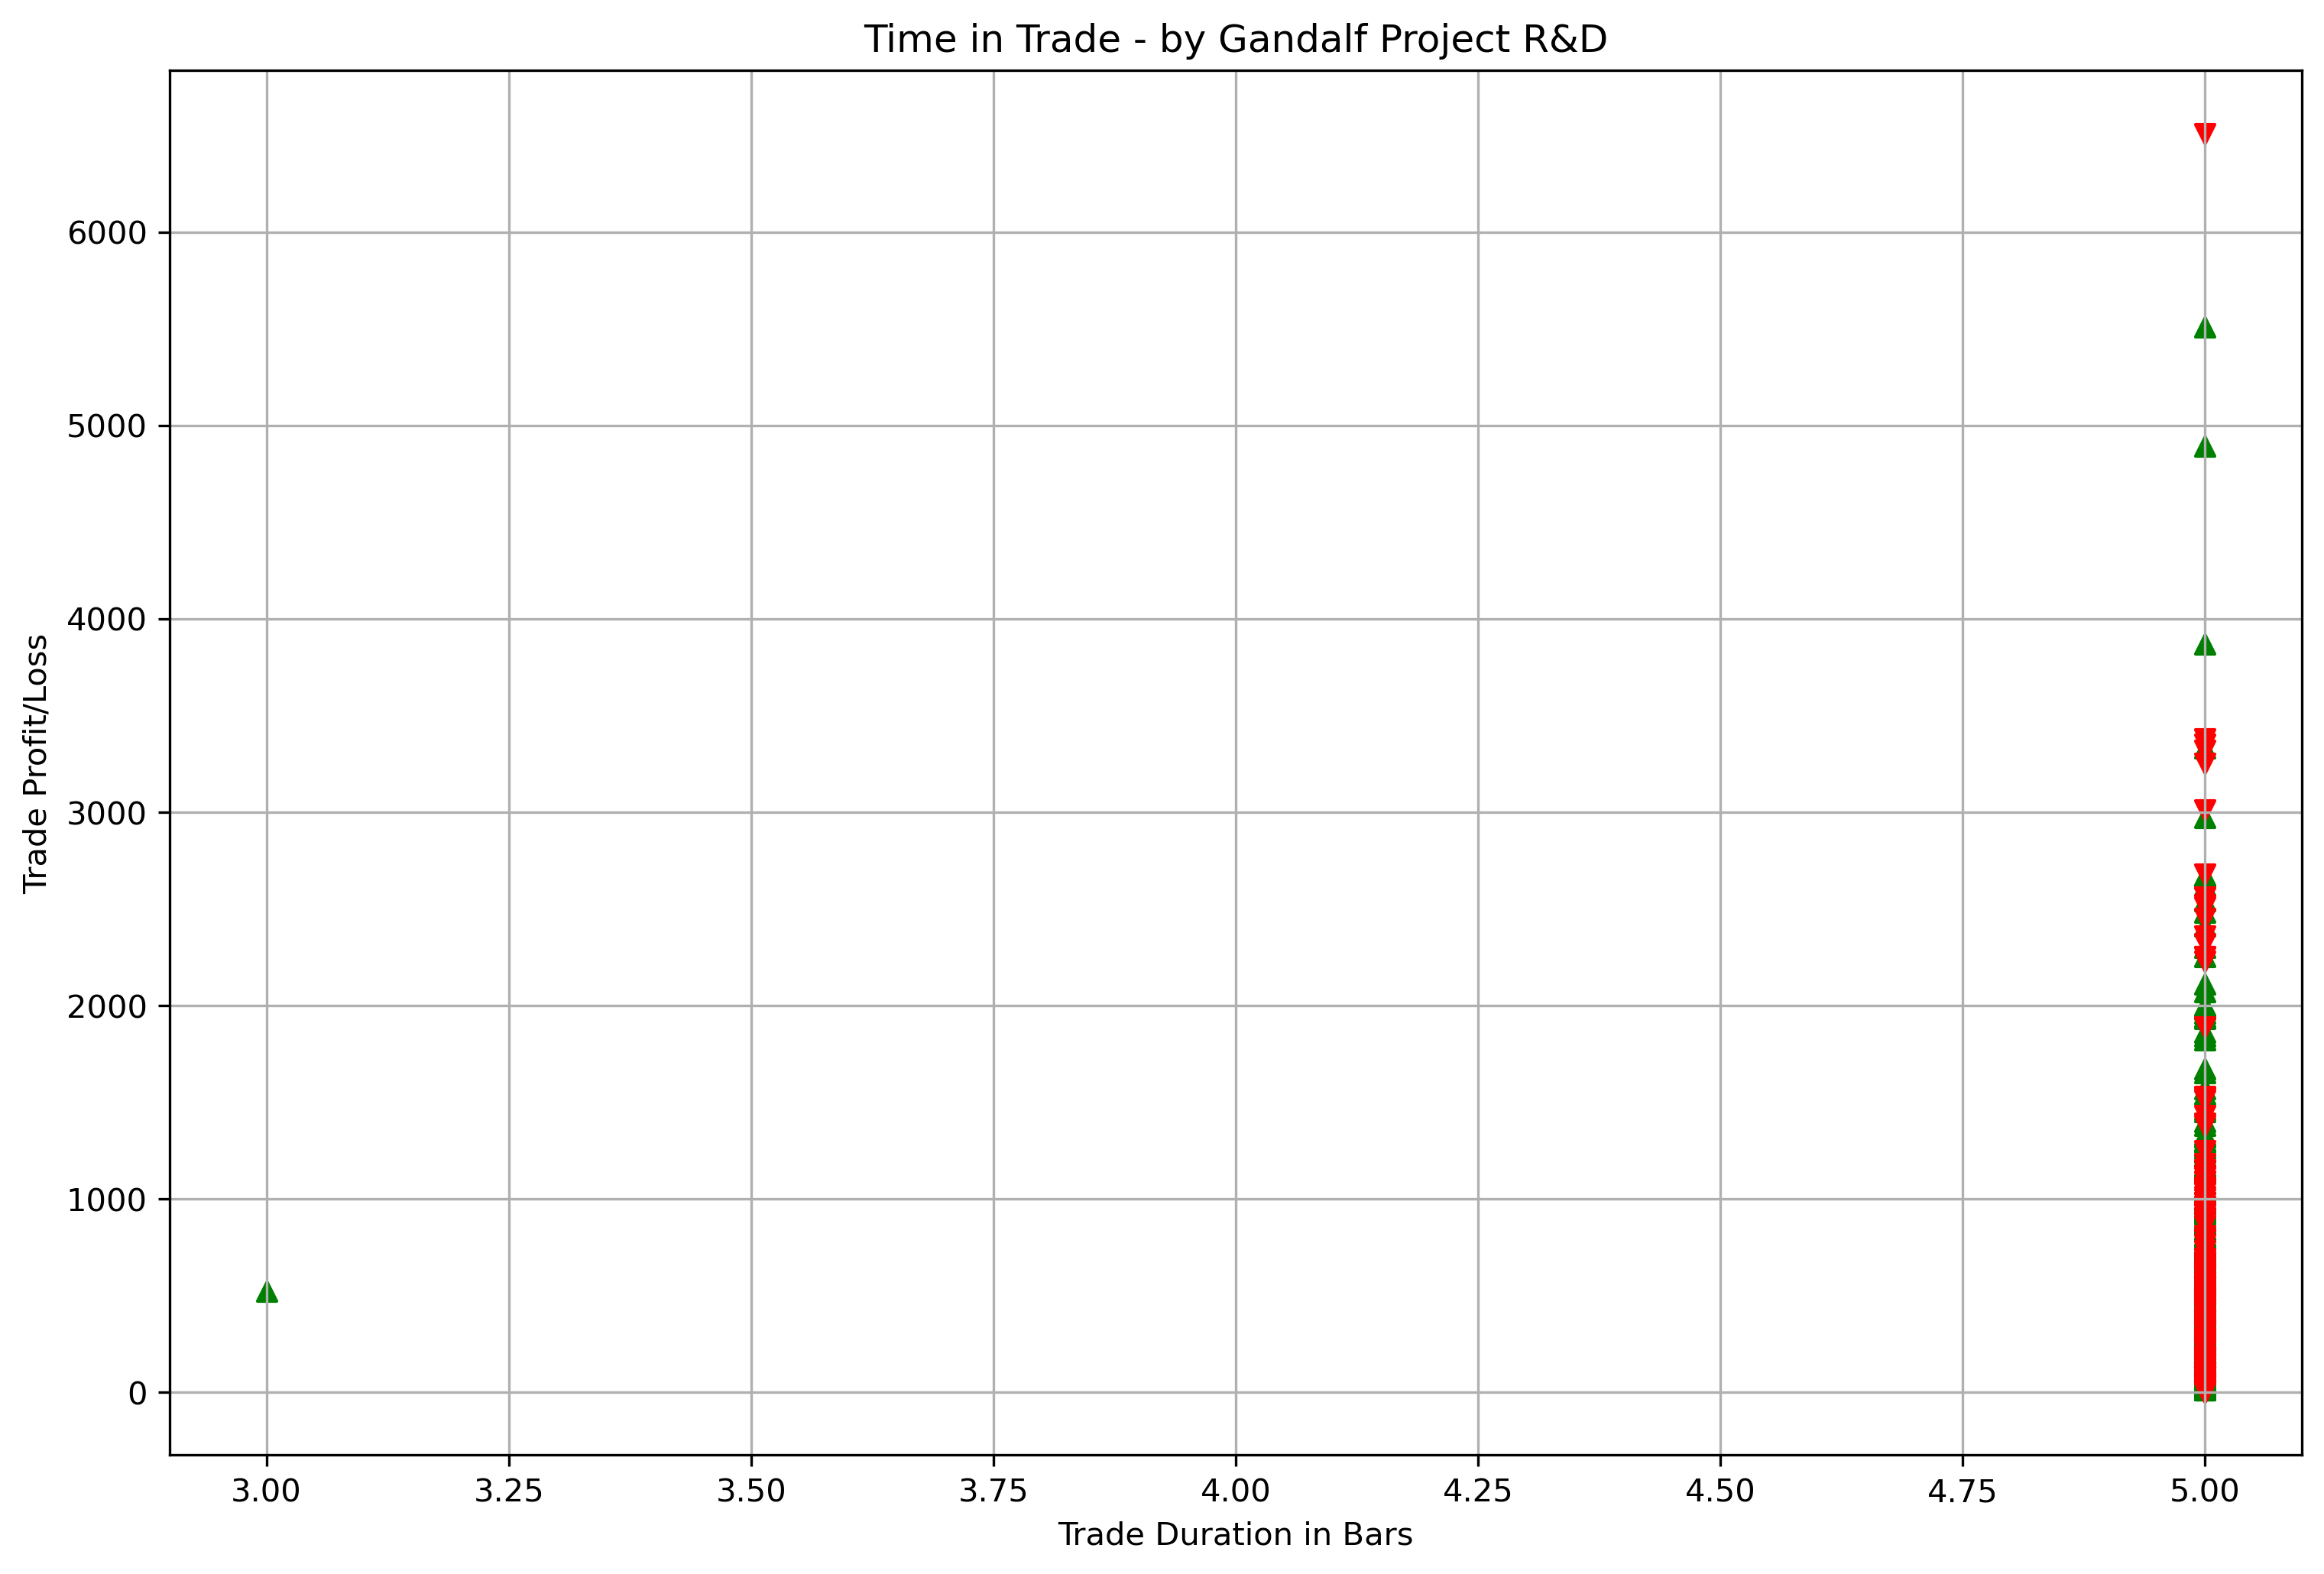

In [23]:
NAME = "Tester"

WRITELOG = False

EXIT_ON_ENTRY_BAR = False
CONSECUTIVE_TRADES = True

COSTS_FIXED = 25.0
# 10 for 10 $ for each transaction (2 * fee each operation)
COSTS_VARIABLE = 0.0
# 1.0 for 1% (2 * fee each operation)
COSTS_PERSHARES = 0.0 
# 0.01 for 1 cent for each shares traded (2 * fee each operation)

INSTRUMENT = 2 # 1: equity, 2: future, 3: crypto/forex
TICK = 0.01
BIGPOINTVALUE = BIGPOINTVALUE
ORDER_TYPE = "market"
MAX_INTRADAY_OPERATIONS = 100

QUANTITY = 1
MARGIN_PERCENT = 10 # margin to use in capital calculation

TIME_EXIT = TIME_EXIT  # 0 to disable
TIME_EXIT_LOSS = 0  # 0 to disable
TIME_EXIT_GAIN = 0  # 0 to disable

MONEY_STOPLOSS = 0  # 0 to disable
MONEY_TARGET = 0  # 0 to disable

MIN_MONEY_PERCENT_STOPLOSS = 0
PERCENT_STOPLOSS = 0.0  # 0 to disable

MIN_MONEY_PERCENT_TARGET = 0
PERCENT_TARGET = 0.0  # 0 to disable

enter_level = dataset.high

exit_rules_loss = False

exit_rules_gain = False 

target_level = 0 # 0 to disable

stop_level = 0 # 0 to disable

DIRECTION = "long"
enter_rules = dataset["entry_rule"]
exit_rules = False

tradelist_l, open_equity_l, closed_equity_l, operation_equity_l = apply_trading_system(dataset, INSTRUMENT, QUANTITY, MARGIN_PERCENT, BIGPOINTVALUE, TICK, DIRECTION,
                                                                               COSTS_FIXED, COSTS_VARIABLE, COSTS_PERSHARES, 
                                                                               ORDER_TYPE, enter_level, enter_rules, MAX_INTRADAY_OPERATIONS, 
                                                                               exit_rules, exit_rules_loss, exit_rules_gain,
                                                                               target_level, stop_level,
                                                                               TIME_EXIT, TIME_EXIT_LOSS, TIME_EXIT_GAIN, 
                                                                               MONEY_STOPLOSS, MONEY_TARGET, 
                                                                               PERCENT_STOPLOSS, MIN_MONEY_PERCENT_STOPLOSS, 
                                                                               PERCENT_TARGET, MIN_MONEY_PERCENT_TARGET, WRITELOG, EXIT_ON_ENTRY_BAR, CONSECUTIVE_TRADES)

# True: Interactive, False: Static
performance_report(dataset, tradelist_l, closed_equity_l, open_equity_l, 100000, 0, MARGIN_PERCENT, False)